# Exam DS 807 - Group: Fri-30034-25

**Note for reader:** 

To ensure proper functionality, please load in all libraries from below and run the entire "Data Management" section. 
This should ensure full functionality of the notebook. 

**Note** however, *runtime is extremely long*, and it is not recommended to run the code for questions 1.2 - 2.2.

2.3, 3.1, 3.2 only rely on loading in saved models aside from importing the initial data and are thus not computationaly expensive to run. 

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.cm as cm
import seaborn as sns
from sklearn import svm
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import asarray
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from keras.applications.vgg16 import VGG16

## Data management

### 12k train, test, val split

#### Labeling Data and converting images to array values

Function for loading in images to array container with respective filename. 

Images converted from RGB to gray scale. 

In [2]:
def load_image_function(path):
    images = [] # empty list placeholder
    labels = [] # empty list placeholder
    container = [] # container to validate correct labels
    for filename in os.listdir(path):
        container.append(filename) # add filename to container     
        CCDY_img = load_img(path + f'/{filename}', target_size = (56, 106),
        color_mode="grayscale")                  
        CCDY_img = img_to_array(CCDY_img)
        images.append(CCDY_img) # append the photo to the images. The images list contains a list of arrays       
    return asarray(images), container; # not interested in list of arrays, but array containing lists. Asarray does this. Returns three arrays


Function for creating a DF with imported sample values and image arrays. 

Each samples is labeled for the CC-D-Y classes. 

In [3]:
def load_img_data ():
    string_digits = pd.read_csv('DIDA_12000_String_Digit_Labels.csv', 
                 header = None, 
                 names=["index", "string"])
    # create empty class columns
    string_digits['CC'] = 0
    string_digits['D'] = 0
    string_digits['Y'] = 0
    string_digits = string_digits.astype(str)
    # Iterate string digits and append classes
    for i, row in string_digits.iterrows():
        if len(row['string']) != 4:
            row['CC'] = '1'
            row['D'] = '10'
            row['Y'] = '10'
        else:
            row['D'] = row['string'][2]
            row['Y'] = row['string'][3]
            if row['string'][0:2] == '18':
                row['CC']='0'
            else:
                row['CC']='1'
    # End of class labeling on string_digits.
    #
    # Start: create img_df containing scaled images 
    image_array, filename = load_image_function('DIDA_12000_String_Digit_Images/DIDA_1')
    # and convert to a img_df
    img_df = pd.DataFrame({'filename': filename, 'img_value': list(image_array)}, 
                          columns=['filename', 'img_value'])
    # Create proper index value in img_df to allow merge on string_digits
    img_df['index'] = img_df['filename']
    for i, row in img_df.iterrows():
        row['index'] = str(img_df['index'][i]).split('.')[0]
    img_df
    # End of creating img_df
    #
    # Start: merge img_df with string_digits
    # match index type on dataframes to merge
    string_digits['index'] = string_digits['index'].astype(int)
    img_df['index'] = img_df['index'].astype(int)
    # Merge dataframes
    df_img_classes = string_digits.merge(img_df)
    # Rearrange order of dataframe
    df_img_classes = df_img_classes.reindex(columns= ['index', 'string', 'CC', 'D', 'Y', 'img_value', 'filename'])
    # End og merging data frames
    return df_img_classes


Load the data eith image arrays and labels, shuffle the values around. 

In [4]:
#load data and shuffle them around
df = load_img_data()
df = df.sample(frac=1).reset_index(drop=True)
df

index string CC  D  Y  \
0       1422   1813  0  1  3   
1        589   1820  0  2  0   
2       3670   1815  0  1  5   
3       3615   1839  0  3  9   
4       1908   1828  0  2  8   
...      ...    ... .. .. ..   
11995   3847   1837  0  3  7   
11996   6630   1822  0  2  2   
11997   3898   1803  0  0  3   
11998   1319   1836  0  3  6   
11999  10119   1801  0  0  1   

                                               img_value   filename  
0      [[[150.0], [149.0], [150.0], [153.0], [153.0],...   1422.jpg  
1      [[[137.0], [136.0], [133.0], [132.0], [133.0],...    589.jpg  
2      [[[145.0], [148.0], [144.0], [143.0], [143.0],...   3670.jpg  
3      [[[122.0], [123.0], [123.0], [124.0], [121.0],...   3615.jpg  
4      [[[142.0], [146.0], [144.0], [139.0], [140.0],...   1908.jpg  
...                                                  ...        ...  
11995  [[[89.0], [87.0], [90.0], [71.0], [77.0], [86....   3847.jpg  
11996  [[[131.0], [130.0], [131.0], [132.0], [132.0],...   6630.jpg  
11997  [[[141.0], [140.0], [140.0], [141.0], [142.0],...   3898.jpg  
11998  [[[151.0], [152.0], [151.0], [151.0], [149.0],...   1319.jpg  
11999  [[[155.0], [155.0], [156.0], [157.0], [155.0],...  10119.jpg  

[12000 rows x 7 columns]

#### Defining fixed train, test and valdiation sets.

In [5]:
df = df.drop(columns=['index','string','filename'])

#### Split train, val, test

##### Subsetting dataframe

In [6]:
x_train = df.loc[0:7679]
x_val = df.loc[7680:9599]
x_test = df.loc[9600:11999]

##### Creating label variables, typecasting to np.uint8.

In [7]:
#### training labels ###
Y_train = x_train['Y']
Y_train = Y_train.astype(np.uint8)
D_train = x_train['D']
D_train = D_train.astype(np.uint8)
CC_train = x_train['CC']
CC_train = CC_train.astype(np.uint8)

#### validation labels ###
Y_val = x_val['Y']
Y_val = Y_val.astype(np.uint8)
D_val = x_val['D']
D_val = D_val.astype(np.uint8)
CC_val = x_val['CC']
CC_val = CC_val.astype(np.uint8)

#### test labels ###
Y_test = x_test['Y']
Y_test = Y_test.astype(np.uint8)
D_test = x_test['D']
D_test = D_test.astype(np.uint8)
CC_test = x_test['CC']
CC_test = CC_test.astype(np.uint8)


##### Creating image value variables to allow for models to read images. Image values are normalized. 

In [8]:
# train
values = np.zeros(shape=(len(x_train),56,106,1))
i = 0
j = 0
while i < len(x_train):
    values[i] = x_train['img_value'][j]
    i += 1
    j+=1
x_train = values/255

# val
values = np.zeros(shape=(len(x_val),56,106,1))
i = 0
j = 7680
while i < len(x_val):
    values[i] = x_val['img_value'][j]
    i += 1
    j+=1
x_val = values/255

# test
values = np.zeros(shape=(len(x_test),56,106,1))
i = 0
j = 9600
while i < len(x_test):
    values[i] = x_test['img_value'][j]
    i += 1
    j+=1
x_test = values/255


### 30k test set, import

Csv file is read, labelling performed.

In [9]:
csv_30 = pd.read_csv('30_samples_labeled_csv.csv',header=None, names=["index", "string"],delimiter=';')
csv_30['CC'] = 0
csv_30['D'] = 0
csv_30['Y'] = 0
csv_30 = csv_30.astype(str)
# Iterate string digits and append classes
for i, row in csv_30.iterrows():
    if len(row['string']) != 4:
        row['CC'] = '1'
        row['D'] = '10'
        row['Y'] = '10'
    else:
        row['D'] = row['string'][2]
        row['Y'] = row['string'][3]
        if row['string'][0:2] == '18':
            row['CC']='0'
        else:
            row['CC']='1'
            

Load in images by matching indexes with file names relying on functions from section "12k train, test, val split". 

In [10]:
#os.chdir(path_images)
image_array, filename = load_image_function('30_samples')

# and convert to a img_df
img_df = pd.DataFrame({'filename': filename, 'img_value': list(image_array)}, 
                        columns=['filename', 'img_value'])
# Create proper index value in img_df to allow merge on Hee_csv
img_df['index'] = img_df['filename']
for i, row in img_df.iterrows():
    row['index'] = str(img_df['index'][i]).split('.')[0]
img_df
# End of creating img_df
#
# Start: merge img_df with Hee_csv
# match index type on dataframes to merge
csv_30['index'] = csv_30['index'].astype(int)
img_df['index'] = img_df['index'].astype(int)
# Merge dataframes
df_img_classes = csv_30.merge(img_df)
# Rearrange order of dataframe
df_img_classes = df_img_classes.reindex(columns= ['index', 'string', 'CC', 'D', 'Y', 'img_value', 'filename'])
# End og merging data frames


Typecast labels to np.uint8 and normalize image values. 

In [11]:
k30_labels_CC = df_img_classes['CC'].astype(np.uint8)
k30_labels_D = df_img_classes['D'].astype(np.uint8)
k30_labels_Y = df_img_classes['Y'].astype(np.uint8)


In [12]:
k30_img_vals =  df_img_classes['img_value']
values = np.zeros(shape=(len(k30_img_vals),56,106,1))
i = 0
j = 0
while i < len(k30_img_vals):
    values[i] = k30_img_vals[j]
    i += 1
    j+=1
k30_img_vals = values/255


### 12k, label CC 50/50, import

Importing data from csv and labeling them for respective classes. 

In [13]:
data_5050 = pd.read_csv('50_50_set.csv',header=None, names=["index", "string"],delimiter=';')
data_5050['CC'] = 0
data_5050['D'] = 0
data_5050['Y'] = 0
data_5050 = data_5050.astype(str)
# Iterate string digits and append classes
for i, row in data_5050.iterrows():
    if len(row['string']) != 4:
        row['CC'] = '1'
        row['D'] = '10'
        row['Y'] = '10'
    else:
        row['D'] = row['string'][2]
        row['Y'] = row['string'][3]
        if row['string'][0:2] == '18':
            row['CC']='0'
        else:
            row['CC']='1'
print(data_5050)

     index string CC  D  Y
0      270   1920  1  2  0
1    10690   1920  1  2  0
2    10866   2021  1  2  1
3     9261   2022  1  2  2
4    10619   2025  1  2  5
..     ...    ... .. .. ..
773    401   1812  0  1  2
774    402   1813  0  1  3
775    403   1809  0  0  9
776    404   1809  0  0  9
777    405   1809  0  0  9

[778 rows x 5 columns]


Using functions from "12k train, test, val split" labelled data frame is synced up with image values imported as RGB and converted to grayscale.

In [14]:
#os.chdir(path_images)
image_array, filename = load_image_function('DIDA_12000_String_Digit_Images/DIDA_1/')

# and convert to a img_df
img_df = pd.DataFrame({'filename': filename, 'img_value': list(image_array)}, 
                        columns=['filename', 'img_value'])
# Create proper index value in img_df to allow merge on data_5050
img_df['index'] = img_df['filename']
for i, row in img_df.iterrows():
    row['index'] = str(img_df['index'][i]).split('.')[0]
img_df
# End of creating img_df
#
# Start: merge img_df with data_5050
# match index type on dataframes to merge
data_5050['index'] = data_5050['index'].astype(int)
img_df['index'] = img_df['index'].astype(int)
# Merge dataframes
df_img_classes = data_5050.merge(img_df)
# Rearrange order of dataframe
df_img_classes = df_img_classes.reindex(columns= ['index', 'string', 'CC', 'D', 'Y', 'img_value', 'filename'])
# End og merging data frames

Shuffle the data.

In [15]:
df_img_classes = df_img_classes.sample(frac=1).reset_index(drop=True)

Typecast labels to np.uint8. 

In [16]:
labels_CC_5050 = df_img_classes['CC']
labels_CC_5050 = labels_CC_5050.astype(np.uint8)

Prepare image valeus by normalizing them.

In [17]:
data_5050 =  df_img_classes['img_value']
values = np.zeros(shape=(len(data_5050),56,106,1))
i = 0
j = 0
while i < len(data_5050):
    values[i] = data_5050[j]
    i += 1
    j+=1
data_5050 = values/255

Split data into train, test and validation sets. 

In [18]:
train_5050 = data_5050[0:577]
val_5050 = data_5050[578:677]
test_5050 = data_5050[678:777]
train_5050_label = labels_CC_5050[0:577]
val_5050_label = labels_CC_5050[578:677]
test_5050_label = labels_CC_5050[678:777]

Revert grayscale imagery to RGB by stacking layers.

In [19]:
train_5050 = tf.image.grayscale_to_rgb(tf.constant(train_5050))
val_5050 = tf.image.grayscale_to_rgb(tf.constant(val_5050))
test_5050 = tf.image.grayscale_to_rgb(tf.constant(test_5050))

## Score Calculaters

Sequence score calculator for deep- and non-deep learning.

In [48]:
def sequence_calc(model_CC,model_D,model_Y,CC_test,D_test,Y_test,x_test):
    preds_D = model_D.predict(x_test)
    preds_Y = model_Y.predict(x_test)
    preds_CC = model_CC.predict(x_test)
    CC_array = np.array(CC_test)
    D_array = np.array(D_test)
    Y_array = np.array(Y_test)
    score = 0.0
    i = 0
    while i < len(CC_array):
        if int(CC_array[i]) == preds_CC[i]:
            if int(D_array[i]) == preds_D[i]:
                if int(Y_array[i]) == preds_Y[i]:
                    score = score + 1
        i= i + 1
    return score

Character score calcualtor. Used in non deep learning.

In [49]:
def score_calc(model,x_test,y_test):
    score = 0.0
    preds = model.predict(x_test)
    i = 0
    for row in y_test:
        if str(row) == str(preds[i][0]):
            score = score + (1/3)
        i= i + 1
    return score

Character score calcualtor. Used in deep learning.

In [50]:
def accuracy_calc(model,y_test,x_test):
    preds = model.predict(x_test)
    classes = np.argmax(preds, axis = 1)
    score = 0.0
    i = 0
    for row in y_test:
        if int(row) == classes[i]:
            score = score + (1/3)
        i= i + 1
    return score

## Question 1.1

Section discussing theory in the report

## Question 1.2

Please run section score calculators to import functions for calculating scores. 

### Flattening grayscale image arrays.

In [10]:
#Flattening 12k data
x_train_flat = x_train.reshape((len(x_train), -1))
x_val_flat = x_val.reshape((len(x_val), -1))
x_test_flat = x_test.reshape((len(x_test), -1))

#Flattening 30k data
n_samples = len(k30_img_vals)
k30_flat = k30_img_vals.reshape((n_samples, -1))

### SVM

Running a hyperparameter search on the SVM classifier. 

Kernel function, Degree of polynomials, Intensity of squared L2 regualrization,  gamma, decision type.

Accuracy is measures as valdiation accuracy. 

In [ ]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
Cs = [1,2,3]
Ds = [1,2,3,4]
gammas = ['scale','auto']
decisions = ['ovr', 'ovo']
results = []

for kernel in kernels:
        if kernel == 'poly':
            for C in Cs:
                for D in Ds:
                    for gamma in gammas:
                        for decision in decisions:
                            svm_current = svm.SVC(kernel=kernel, 
                                                    degree=D,
                                                    C =C,
                                                    gamma = gamma,
                                                    random_state = 2022,
                                                    decision_function_shape = decision)
                            svm_current.fit(x_train_flat, CC_train)
                            val_hat = svm_current.predict(x_val_flat)
                            accuracy = accuracy_score(val_hat, CC_val)
                            #
                            results.append([accuracy, kernel, C, gamma, decision, D])
                            print([accuracy, kernel, C, gamma, decision, None])
        else:
            for C in Cs:
                for gamma in gammas:
                    for decision in decisions:
                        svm_current = svm.SVC(kernel=kernel,
                                              C=C,
                                              gamma = gamma,
                                              decision_function_shape = decision,
                                              random_state = 2022)
                        svm_current.fit(x_train_flat, CC_train)
                        val_hat = svm_current.predict(x_val_flat)
                        accuracy = accuracy_score(val_hat, CC_val)
                        #
                        results.append([accuracy, kernel, C, gamma, decision, None])
                        print([accuracy, kernel, C, gamma, decision, None])

results = pd.DataFrame(results)
results.columns = ['Accuracy', 'Kernel','C', 'Gamma', 'Decision', 'Degree']
results


[0.9614583333333333, 'linear', 1, 'scale', 'ovr', None]
[0.9614583333333333, 'linear', 1, 'scale', 'ovo', None]
[0.9614583333333333, 'linear', 1, 'auto', 'ovr', None]
[0.9614583333333333, 'linear', 1, 'auto', 'ovo', None]
[0.9609375, 'linear', 2, 'scale', 'ovr', None]
[0.9609375, 'linear', 2, 'scale', 'ovo', None]
[0.9609375, 'linear', 2, 'auto', 'ovr', None]
[0.9609375, 'linear', 2, 'auto', 'ovo', None]
[0.9609375, 'linear', 3, 'scale', 'ovr', None]
[0.9609375, 'linear', 3, 'scale', 'ovo', None]
[0.9609375, 'linear', 3, 'auto', 'ovr', None]
[0.9609375, 'linear', 3, 'auto', 'ovo', None]
[0.9651041666666667, 'poly', 1, 'scale', 'ovr', None]
[0.9651041666666667, 'poly', 1, 'scale', 'ovo', None]
[0.9625, 'poly', 1, 'auto', 'ovr', None]
[0.9625, 'poly', 1, 'auto', 'ovo', None]
[0.9661458333333334, 'poly', 1, 'scale', 'ovr', None]
[0.9661458333333334, 'poly', 1, 'scale', 'ovo', None]
[0.9625, 'poly', 1, 'auto', 'ovr', None]
[0.9625, 'poly', 1, 'auto', 'ovo', None]
[0.9609375, 'poly', 1, 'sc

Accuracy   Kernel  C  Gamma Decision  Degree
0   0.961458   linear  1  scale      ovr     NaN
1   0.961458   linear  1  scale      ovo     NaN
2   0.961458   linear  1   auto      ovr     NaN
3   0.961458   linear  1   auto      ovo     NaN
4   0.960938   linear  2  scale      ovr     NaN
..       ...      ... ..    ...      ...     ...
79  0.962500  sigmoid  2   auto      ovo     NaN
80  0.962500  sigmoid  3  scale      ovr     NaN
81  0.962500  sigmoid  3  scale      ovo     NaN
82  0.962500  sigmoid  3   auto      ovr     NaN
83  0.962500  sigmoid  3   auto      ovo     NaN

[84 rows x 6 columns]

#### Initializing the best SVM and training it on concatenated training and validation data.

In [ ]:
svm_final = svm.SVC(kernel='rbf',
                      C=3,
                      gamma = 'scale',
                      decision_function_shape = 'ovr',
                      random_state = 2022)
svm_final.fit(np.concatenate((x_train_flat, x_val_flat), axis=0), np.concatenate((CC_train, CC_val), axis=0))
val_hat = svm_final.predict(x_val_flat)
accuracy = accuracy_score(val_hat, CC_val)
accuracy

0.9973958333333334

#### Calculating character score on the 12k test data.

In [ ]:
test_score = score_calc(svm_final,Y_test,x_test)
test_score

781.6666666666856

#### Calculating character score on the 30k test data.

In [ ]:
test_score = score_calc(svm_final,k30_flat,k30_labels_CC)
test_score

274.0000000000019

### Catboost

#### Model D Parameter Search

-returning best score.

Commented out values for parameters number_of_iterations, learning_Rate, tree_depth are used in the parameter search.

Active values are those of the best performing model. Accuracy is absed on the valdiation set. 

In [ ]:
results_catboost_D = []
n_iterations = [500]#,200,500]
lr = [0.1]#,0.01]
n_depth = [6]#,4]
loss_f = 'MultiClass'

for iters in n_iterations:
    for ls in lr:
        for depths in n_depth:
            model_D = CatBoostClassifier(iterations=iters,
                                        learning_rate=ls,
                                        depth=depths,
                                        loss_function=loss_f,
                                        task_type="GPU",
                                        devices='0:1')

            model_D.fit(x_train_flat, D_train, verbose=50)
            acc = model_D.score(x_val_flat,D_val)
            # the results from the different hyperparameters are then stored so we can get the best one
            results_catboost_D.append([acc,ls,iters, depths])
results_df_catboost_D = pd.DataFrame(results_catboost_D)
results_df_catboost_D.columns=['accuracy',"learning_rate","n_estimators", "depth"]
#prints the results from best to worst in regards to accuracy, listting the hyperparameters for the result
results_df_catboost_D = results_df_catboost_D.sort_values('accuracy', ascending=False)
results_df_catboost_D

0:	learn: 2.1675784	total: 320ms	remaining: 2m 39s
50:	learn: 1.2035216	total: 13.3s	remaining: 1m 56s
100:	learn: 1.0174397	total: 25.9s	remaining: 1m 42s
150:	learn: 0.8764784	total: 38.3s	remaining: 1m 28s
200:	learn: 0.7694848	total: 50.7s	remaining: 1m 15s
250:	learn: 0.6861388	total: 1m 2s	remaining: 1m 2s
300:	learn: 0.6157047	total: 1m 14s	remaining: 49.5s
350:	learn: 0.5527428	total: 1m 27s	remaining: 36.9s
400:	learn: 0.5027709	total: 1m 38s	remaining: 24.4s
450:	learn: 0.4594386	total: 1m 50s	remaining: 12s
499:	learn: 0.4204521	total: 2m 2s	remaining: 0us


accuracy  learning_rate  n_estimators  depth
0  0.642188            0.1           500      6

#### Model Y Parameter Search

-returning best score.

Commented out values for parameters number_of_iterations, learning_Rate, tree_depth are used in the parameter search.

Active values are those of the best performing model. Accuracy is absed on the valdiation set. 

In [ ]:
results = []
n_iterations = [500]#,200,500]
lr = [0.1]#,0.01]
n_depth = [6]#,4]
loss_f = 'MultiClass'

for iters in n_iterations:
    for ls in lr:
        for depths in n_depth:
            model_Y = CatBoostClassifier(iterations=iters,
                                        learning_rate=ls,
                                        depth=depths,
                                        loss_function=loss_f,
                                        task_type="GPU",
                                        devices='0:1')

            model_Y.fit(x_train_flat, Y_train, verbose=50)
            acc = model_Y.score(x_val_flat,Y_val)
            # the results from the different hyperparameters are then stored so we can get the best one
            results.append([acc,ls,iters, depths])
results_df = pd.DataFrame(results)
results_df.columns=['accuracy',"learning_rate","n_estimators", "depth"]
#prints the results from best to worst in regards to accuracy, listting the hyperparameters for the result
results_df = results_df.sort_values('accuracy', ascending=False)
results_df

0:	learn: 2.3615583	total: 321ms	remaining: 2m 40s
50:	learn: 1.7184887	total: 15.1s	remaining: 2m 13s
100:	learn: 1.4316729	total: 29.6s	remaining: 1m 56s
150:	learn: 1.2419622	total: 43.5s	remaining: 1m 40s
200:	learn: 1.1052926	total: 56.6s	remaining: 1m 24s
250:	learn: 0.9958752	total: 1m 9s	remaining: 1m 9s
300:	learn: 0.9056422	total: 1m 22s	remaining: 54.5s
350:	learn: 0.8293127	total: 1m 34s	remaining: 40.3s
400:	learn: 0.7668663	total: 1m 47s	remaining: 26.5s
450:	learn: 0.7151730	total: 1m 59s	remaining: 13s
499:	learn: 0.6703028	total: 2m 11s	remaining: 0us


accuracy  learning_rate  n_estimators  depth
0  0.566667            0.1           500      6

#### Character scoring on 12k test data.

In [ ]:
model_Y_score = score_calc(model_Y,x_test_flat,Y_test)
model_D_score = score_calc(model_D,x_test_flat,D_test)

In [ ]:
print(model_Y_score)
print(model_D_score)

442.66666666665895
513.9999999999885


#### Character scoring on 30k test data.

In [ ]:
model_Y_score = score_calc(model_Y,k30_flat,k30_labels_Y)
model_D_score = score_calc(model_D,k30_flat,k30_labels_D)

In [ ]:
print(model_Y_score)
print(model_D_score)

121.99999999999935
143.99999999999972


### CC-D-Y sequence score in SVM and CatBoost combination.

Sequence score on 12k test data.

In [ ]:
seq_score = sequence_calc(svm_final,model_D,model_Y,CC_test,D_test,Y_test,x_test_flat)
seq_score

895.0

Sequence score on 30k test data.

In [ ]:
seq_score = sequence_calc(svm_final,model_D,model_Y,k30_labels_CC,k30_labels_D,k30_labels_Y,k30_flat)
seq_score

160.0

## Question 2.1

Section discussing theory in the report.

## Question 2.2

### A: motivate your choice of optimization

#### VGG4 architecture - summary

The basic VGG4 structure used for the CC-D-Y classification. 

The compiles summary reflects the CC classifier, binary. Classifiers D and Y are both multiclass. 

In [14]:
VGG4_binary = tf.keras.models.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # Flattening
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

VGG4_binary.compile(
    optimizer='adam',
    loss= 'binary_crossentropy',
    metrics=['accuracy'],
    ) 

VGG4_binary.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 54, 104, 32)       320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 27, 52, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 25, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 25, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 23, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 11, 128)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 9, 256)        

#### Model CC

Compiling VGG4 for classifier CC.

In [11]:
modelCC = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

modelCC.compile(
    optimizer='adam',
    loss= 'binary_crossentropy',
    metrics=['accuracy'],
    ) 


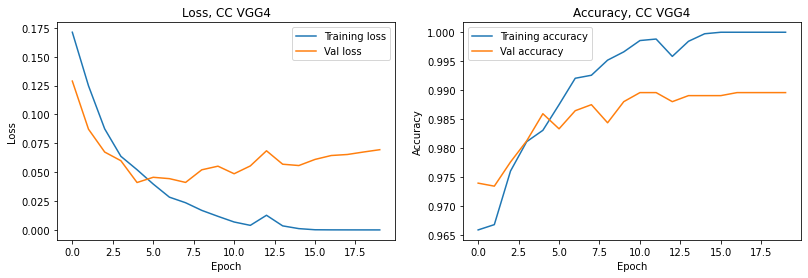

In [24]:
history = modelCC.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, CC VGG4')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label='Training accuracy')
ax.plot(history.history['val_accuracy'], label='Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, CC VGG4')

plt.show()

Evaluate models valdiation accuracy and loss.

In [25]:
modelCC.evaluate(x_val, CC_val, batch_size = len(CC_val))

1/1 [==============================] - 0s 114ms/step - loss: 0.0695 - accuracy: 0.9896


[0.06946999579668045, 0.9895833134651184]

#### Model D

Compiling VGG4 for classifier D.

In [14]:
modelD = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

modelD.compile(
    optimizer='adam',
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 


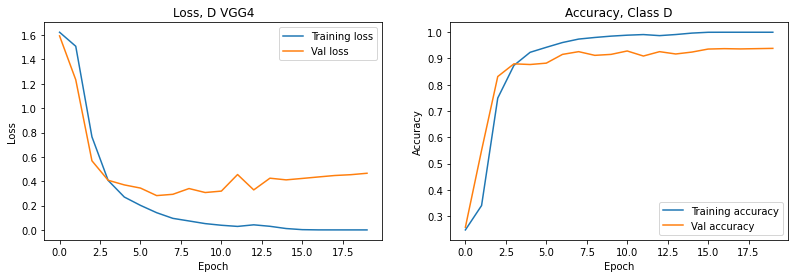

In [15]:
history = modelD.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, D VGG4')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label='Training accuracy')
ax.plot(history.history['val_accuracy'], label='Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Class D')

plt.show()

Evaluate models valdiation accuracy and loss.

In [16]:
modelD.evaluate(x_val, D_val, batch_size = len(D_val))

1/1 [==============================] - 1s 913ms/step - loss: 0.4655 - accuracy: 0.9385


[0.46549665927886963, 0.9385416507720947]

#### Model Y

Compiling VGG4 for classifier Y.

In [12]:
modelY = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

modelY.compile(
    optimizer='adam',
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 


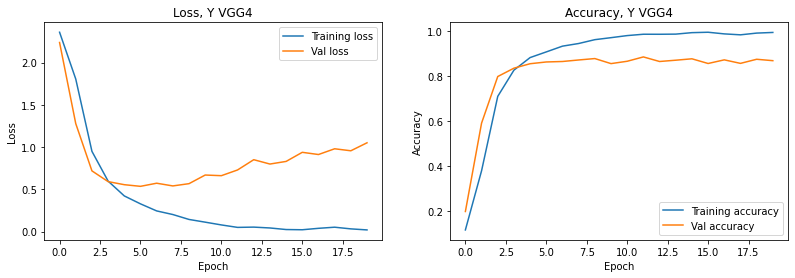

In [27]:
history = modelY.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Y VGG4')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['accuracy'], label='Training accuracy')
ax.plot(history.history['val_accuracy'], label='Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Y VGG4')

plt.show()

Evaluate models valdiation acccuracy and loss.

In [28]:
modelY.evaluate(x_val, Y_val, batch_size = len(Y_val))

1/1 [==============================] - 0s 115ms/step - loss: 1.0501 - accuracy: 0.8687


[1.0501494407653809, 0.8687499761581421]

### B: Opimization through regularization

For each model 30 models are compiled and compared; 10 settings, 3 duplicates each. 

For question 2.2.B this results in 90 CNN's needing to be compiled. 

It is highly encouraged not to run these, and instead inspect already present graphs and accuracy-loss assesments present within this section.

#### **A function for plotting model histories**

In [12]:
def plots (history_new, label, history_old):
    fig = plt.figure(figsize=plt.figaspect(0.3))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history_new.history['loss'], label='Training loss')
    ax.plot(history_new.history['val_loss'], label='Val loss')
    ax.plot(history_old.history['loss'], 'purple', label = 'Training loss (no optim.)')
    ax.plot(history_old.history['val_loss'], 'red', label = 'Val loss (no optim.)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss, '+label)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history_new.history['accuracy'], label='Training accuracy')
    ax.plot(history_new.history['val_accuracy'], label='Val accuracy')
    ax.plot(history_old.history['accuracy'], 'purple', label = 'Training acc (no optim.)')
    ax.plot(history_old.history['val_accuracy'], 'red', label = 'Val acc (no optim.)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy, '+label)

    plt.show()

#### **Model CC**

##### **Saving a history object for the base VGG4 model**

In [13]:
modelCC = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

modelCC.compile(
    optimizer='adam',
    loss= 'binary_crossentropy',
    metrics=['accuracy'],
    ) 
historyCCvgg4 = modelCC.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)

Determine VGG4 validation accuracy:

In [21]:
historyCCvgg4.history['val_accuracy'][-1]

0.9854166507720947

Determine VGG4 validation loss:

In [22]:
historyCCvgg4.history['val_loss'][-1]

0.1500152200460434

##### **Batch normalization**

###### **-2 first layers**

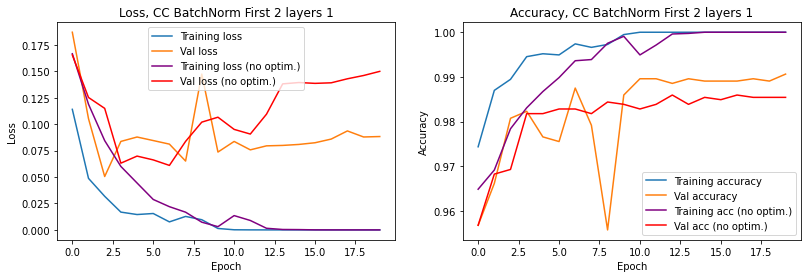

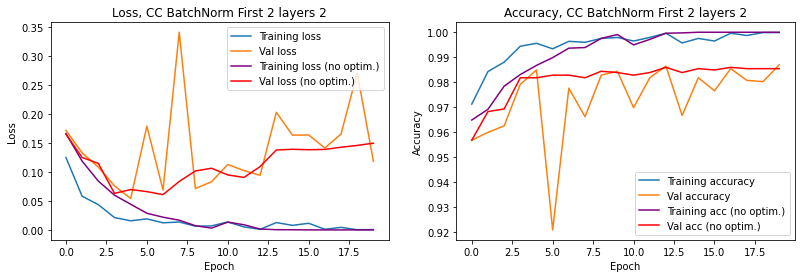

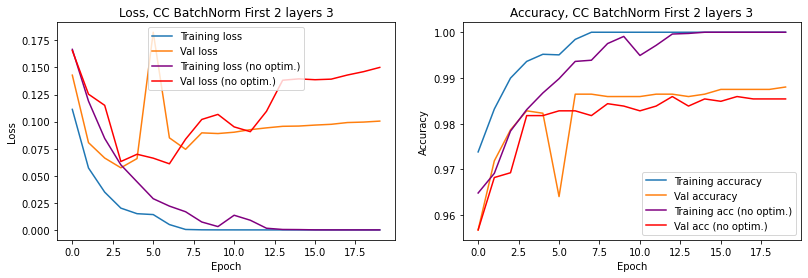

In [28]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyCCbatchFIRST1 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCCbatchFIRST1,'CC BatchNorm First 2 layers '+str(i), historyCCvgg4)
    elif i ==2:
        historyCCbatchFIRST2 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCCbatchFIRST2,'CC BatchNorm First 2 layers '+str(i), historyCCvgg4)   
    else:
        historyCCbatchFIRST3 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCCbatchFIRST3,'CC BatchNorm First 2 layers '+str(i), historyCCvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [31]:
historyCCbatchFIRST1.history['val_accuracy'][-1]

0.9906250238418579

In [32]:
historyCCbatchFIRST1.history['val_loss'][-1]

0.0883462131023407

###### **-2 last layers**

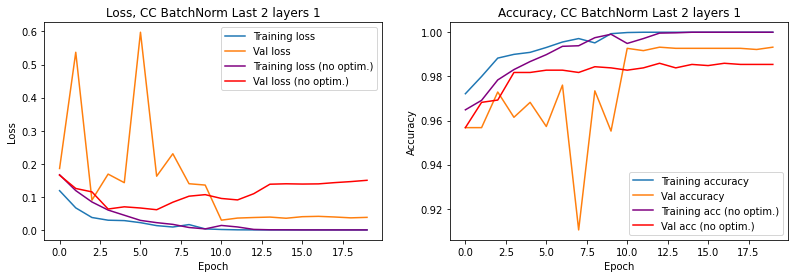

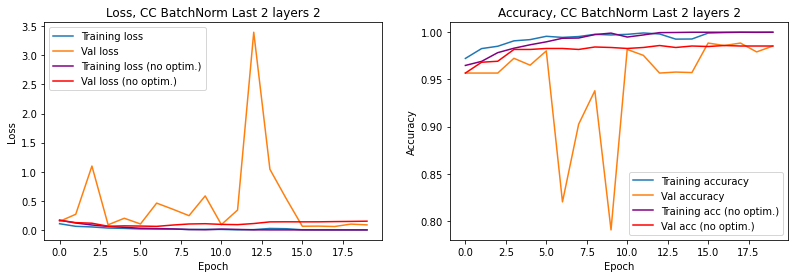

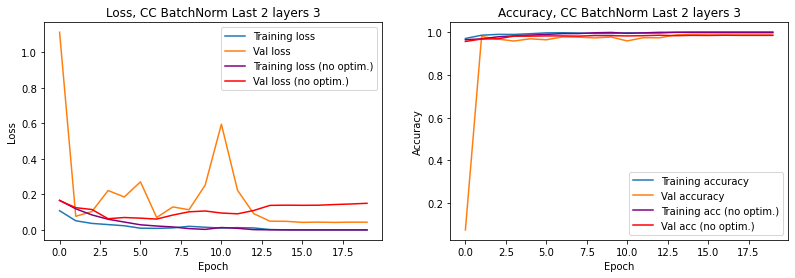

In [65]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyCCbatchLAST1 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCCbatchLAST1,'CC BatchNorm Last 2 layers '+str(i), historyCCvgg4)
    elif i ==2:
        historyCCbatchLAST2 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCCbatchLAST2,'CC BatchNorm Last 2 layers '+str(i), historyCCvgg4)   
    else:
        historyCCbatchLAST3 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCCbatchLAST3,'CC BatchNorm Last 2 layers '+str(i), historyCCvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [68]:
historyCCbatchLAST3.history['val_accuracy'][-1]

0.9921875

In [69]:
historyCCbatchLAST3.history['val_loss'][-1]

0.0436091423034668

###### **-all 4 layers**

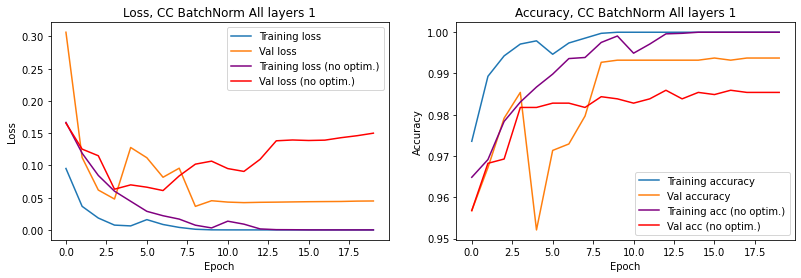

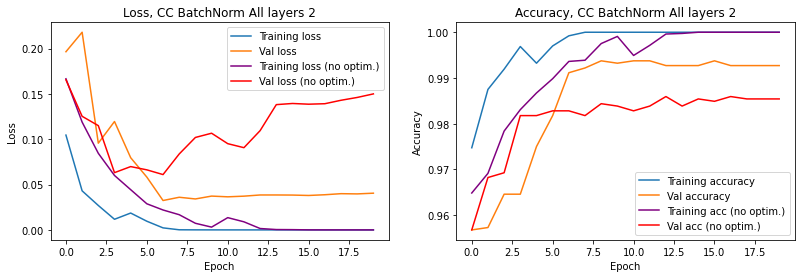

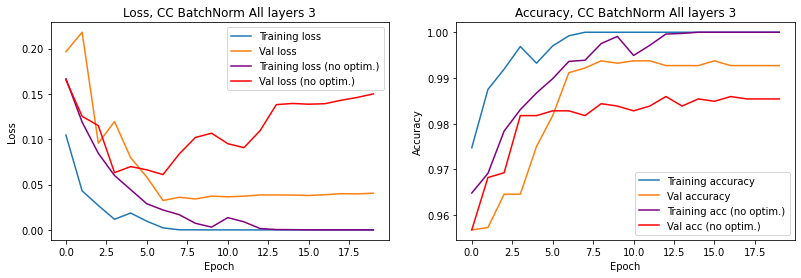

In [24]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 
    
    if i == 1:
        historyCCbatchALL1 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCCbatchALL1,'CC BatchNorm All layers '+str(i), historyCCvgg4)
    elif i ==2:
        historyCCbatchALL2 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCCbatchALL2,'CC BatchNorm All layers '+str(i), historyCCvgg4)   
    else:
        historyCCbatchALL3 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCCbatchALL3,'CC BatchNorm All layers '+str(i), historyCCvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [25]:
historyCCbatchALL1.history['val_accuracy'][-1]

0.9937499761581421

In [26]:
historyCCbatchALL1.history['val_loss'][-1]

0.044871736317873

##### **Learning rates**

###### **0.001**

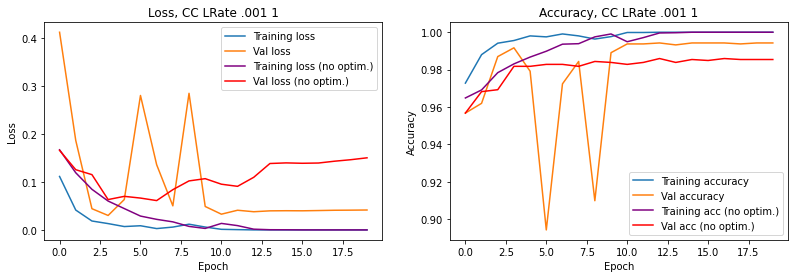

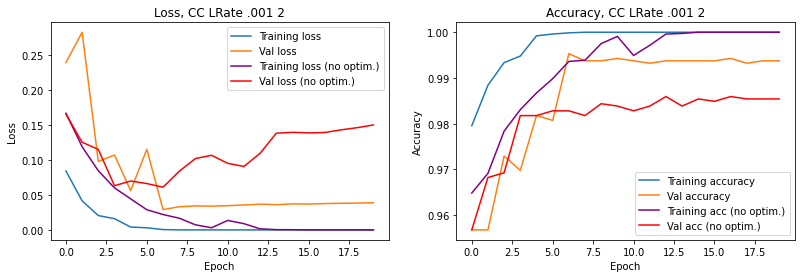

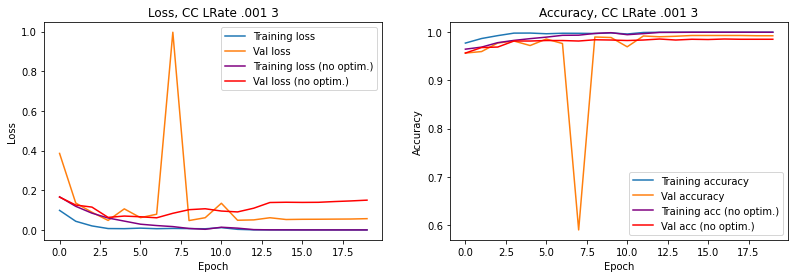

In [70]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyCClearning1_1 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCClearning1_1,'CC LRate .001 '+str(i), historyCCvgg4)
    elif i ==2:
        historyCClearning1_2 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCClearning1_2,'CC LRate .001 '+str(i), historyCCvgg4)   
    else:
        historyCClearning1_3 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCClearning1_3,'CC LRate .001 '+str(i), historyCCvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [82]:
historyCClearning1_1.history['val_accuracy'][-1]

0.9942708611488342

In [83]:
historyCClearning1_1.history['val_loss'][-1]

0.041429031640291214

###### **0.0008**

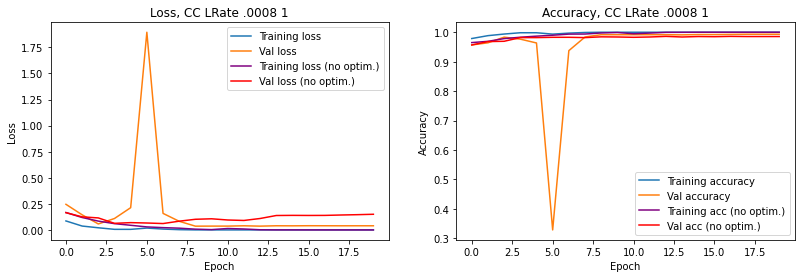

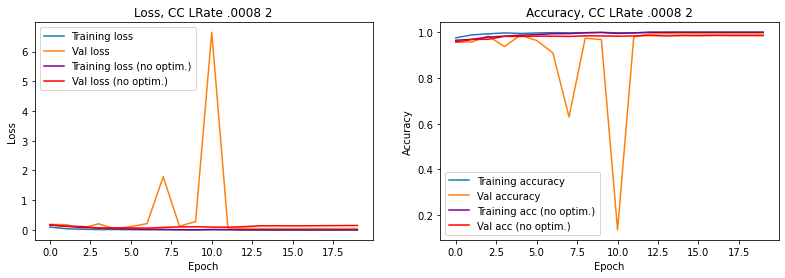

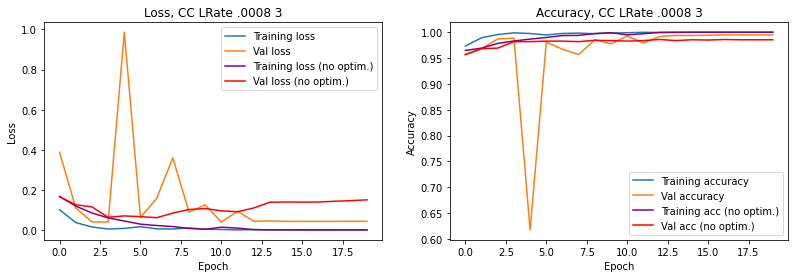

In [71]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyCClearning08_1 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCClearning08_1,'CC LRate .0008 '+str(i), historyCCvgg4)
    elif i ==2:
        historyCClearning08_2 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCClearning08_2,'CC LRate .0008 '+str(i), historyCCvgg4)   
    else:
        historyCClearning08_3 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCClearning08_3,'CC LRate .0008 '+str(i), historyCCvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [86]:
historyCClearning08_3.history['val_accuracy'][-1]

0.9947916865348816

In [87]:
historyCClearning08_3.history['val_loss'][-1]

0.04318391531705856

###### **0.0005**

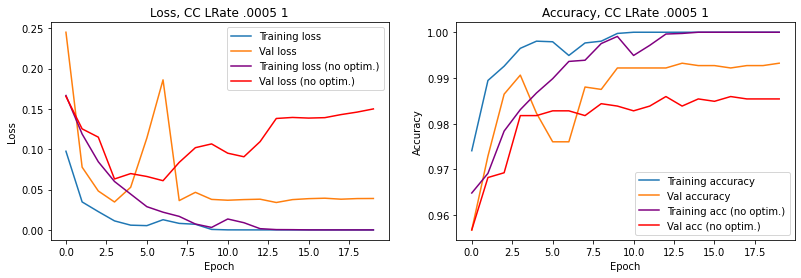

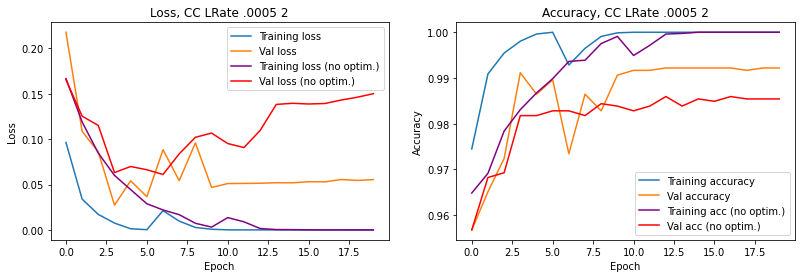

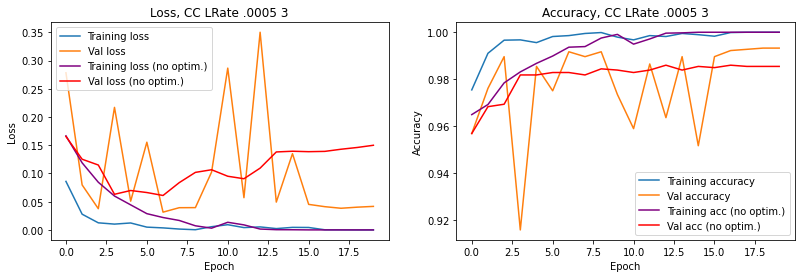

In [72]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyCClearning05_1 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCClearning05_1,'CC LRate .0005 '+str(i), historyCCvgg4)
    elif i ==2:
        historyCClearning05_2 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCClearning05_2,'CC LRate .0005 '+str(i), historyCCvgg4)   
    else:
        historyCClearning05_3 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=20, verbose=0)
        plots(historyCClearning05_3,'CC LRate .0005 '+str(i), historyCCvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [93]:
historyCClearning05_1.history['val_accuracy'][-1]

0.9932291507720947

In [94]:
historyCClearning05_1.history['val_loss'][-1]

0.03897080942988396

##### **Dropout 0.5**

###### **First 2 layers**

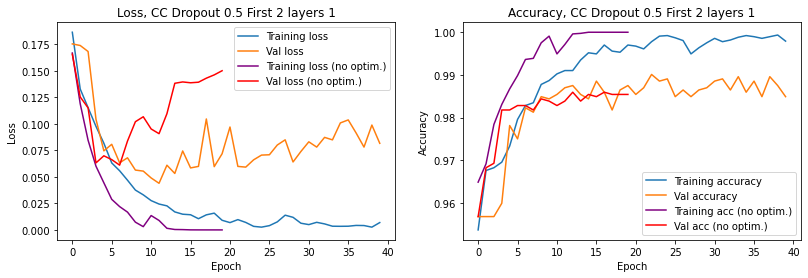

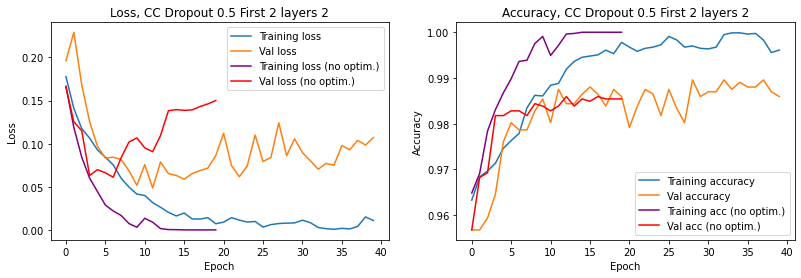

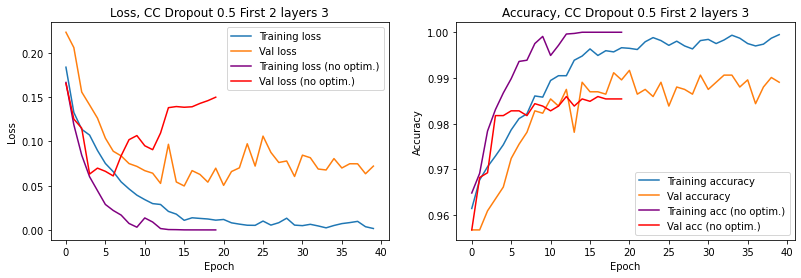

In [131]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyCCdropFIRST1 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=40, verbose=0)
        plots(historyCCdropFIRST1,'CC Dropout 0.5 First 2 layers '+str(i), historyCCvgg4)
    elif i ==2:
        historyCCdropFIRST2 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=40, verbose=0)
        plots(historyCCdropFIRST2,'CC Dropout 0.5 First 2 layers '+str(i), historyCCvgg4)   
    else:
        historyCCdropFIRST3 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=40, verbose=0)
        plots(historyCCdropFIRST3,'CC Dropout 0.5 First 2 layers '+str(i), historyCCvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [140]:
historyCCdropFIRST3.history['val_accuracy'][-1]

0.989062488079071

In [141]:
historyCCdropFIRST3.history['val_loss'][-1]

0.07213462889194489

###### **Last 2 layers**

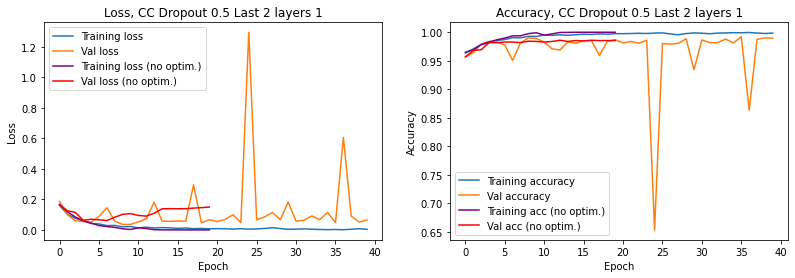

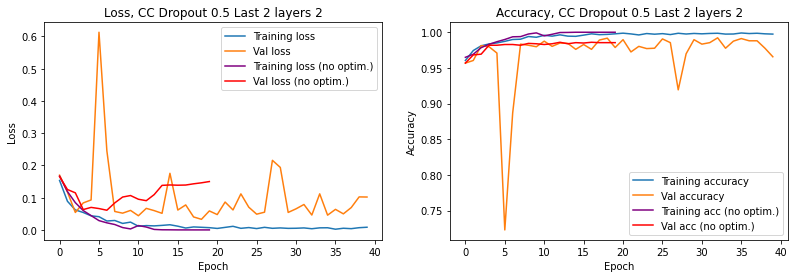

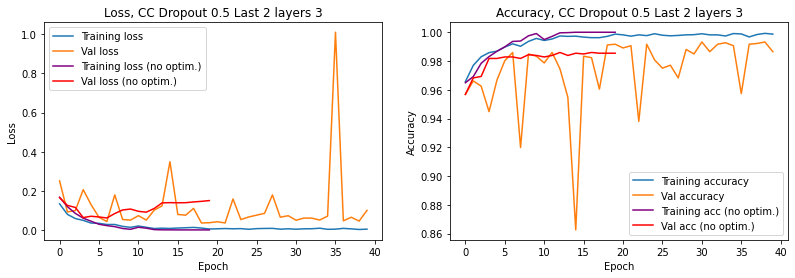

In [132]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyCCdropLAST1 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=40, verbose=0)
        plots(historyCCdropLAST1,'CC Dropout 0.5 Last 2 layers '+str(i), historyCCvgg4)
    elif i ==2:
        historyCCdropLAST2 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=40, verbose=0)
        plots(historyCCdropLAST2,'CC Dropout 0.5 Last 2 layers '+str(i), historyCCvgg4)   
    else:
        historyCCdropLAST3 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=40, verbose=0)
        plots(historyCCdropLAST3,'CC Dropout 0.5 Last 2 layers '+str(i), historyCCvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [145]:
historyCCdropLAST1.history['val_accuracy'][-1]

0.9895833134651184

In [146]:
historyCCdropLAST1.history['val_loss'][-1]

0.06463824957609177

###### **All layers**

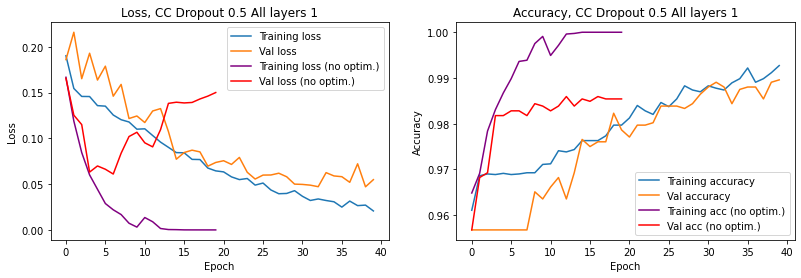

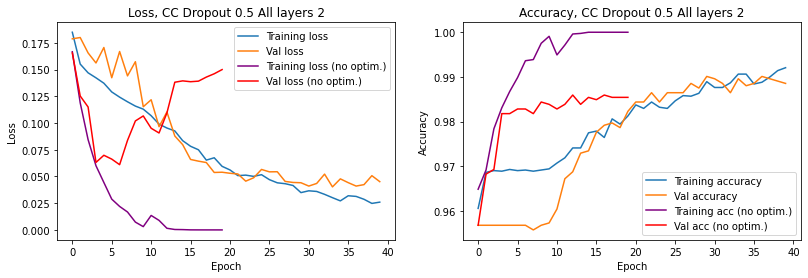

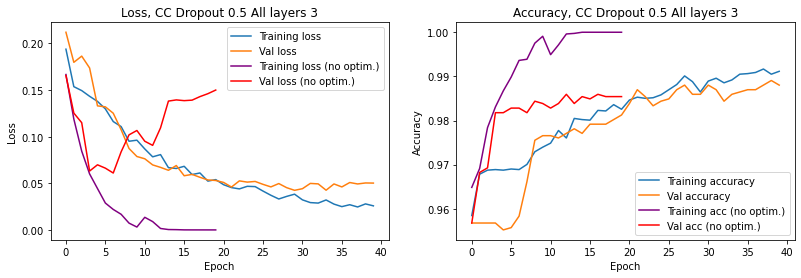

In [133]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'binary_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyCCdropALL1 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=40, verbose=0)
        plots(historyCCdropALL1,'CC Dropout 0.5 All layers '+str(i), historyCCvgg4)
    elif i ==2:
        historyCCdropALL2 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=40, verbose=0)
        plots(historyCCdropALL2,'CC Dropout 0.5 All layers '+str(i), historyCCvgg4)   
    else:
        historyCCdropALL3 = model.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=40, verbose=0)
        plots(historyCCdropALL3,'CC Dropout 0.5 All layers '+str(i), historyCCvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [150]:
historyCCdropALL1.history['val_accuracy'][-1]

0.9895833134651184

In [151]:
historyCCdropALL1.history['val_loss'][-1]

0.05489330738782883

##### **Early stopping**

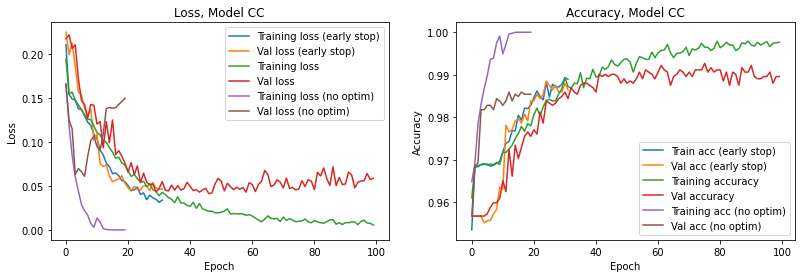

In [192]:
 ### with early stop
model_stop = tf.keras.models.Sequential([
        
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

model_stop.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
loss= 'binary_crossentropy',
metrics=['accuracy'],
) 

history_stop = model_stop.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=100, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

 ### withOUT early stop
model_nostop = tf.keras.models.Sequential([
        
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

model_nostop.compile(
optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
loss= 'binary_crossentropy',
metrics=['accuracy'],
) 

history_no_stop = model_nostop.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=100, verbose=0)

##############################################################

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history_stop.history['loss'], label='Training loss (early stop)')
ax.plot(history_stop.history['val_loss'], label = 'Val loss (early stop)')
ax.plot(history_no_stop.history['loss'], label='Training loss')
ax.plot(history_no_stop.history['val_loss'], label = 'Val loss')
ax.plot(historyCCvgg4.history['loss'], label='Training loss (no optim)')
ax.plot(historyCCvgg4.history['val_loss'], label = 'Val loss (no optim)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model CC')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_stop.history['accuracy'], label='Train acc (early stop)')
ax.plot(history_stop.history['val_accuracy'], label = 'Val acc (early stop)')
ax.plot(history_no_stop.history['accuracy'], label='Training accuracy')
ax.plot(history_no_stop.history['val_accuracy'],  label = 'Val accuracy')
ax.plot(historyCCvgg4.history['accuracy'], label='Training acc (no optim)')
ax.plot(historyCCvgg4.history['val_accuracy'], label = 'Val acc (no optim)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model CC')

plt.show()


Validation accuracy and loss for early stopping model:

In [193]:
history_stop.history['val_accuracy'][-1]

0.9864583611488342

In [209]:
history_stop.history['val_loss'][-1]

0.04660053551197052

Validation accuracy and loss for model with no early stopping:

In [194]:
history_no_stop.history['val_accuracy'][-1]

0.9895833134651184

In [195]:
historyCCvgg4.history['val_accuracy'][-1]

0.9854166507720947

#### **Model D**

##### **Saving a history object for the base VGG4 model**

In [51]:
modelY = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

modelY.compile(
    optimizer='adam',
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

historyDvgg4 = modelY.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)

Measuring models validation accuracy and loss

In [52]:
historyDvgg4.history['val_accuracy'][-1]

0.9307291507720947

In [53]:
historyDvgg4.history['val_loss'][-1]

0.5557824969291687

##### **Batch normalization**

###### **-2 first layers**

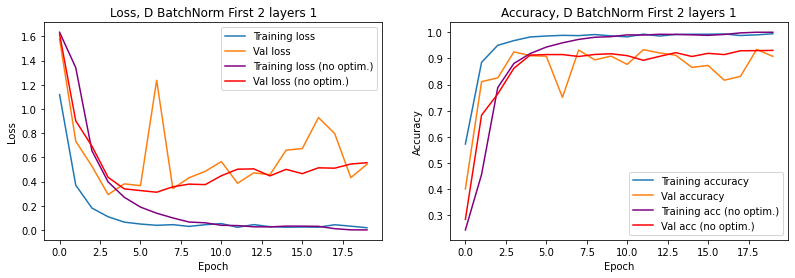

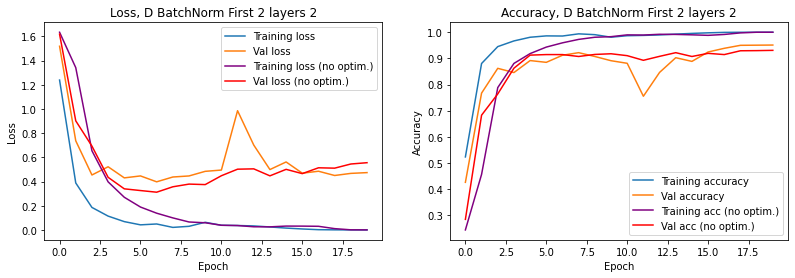

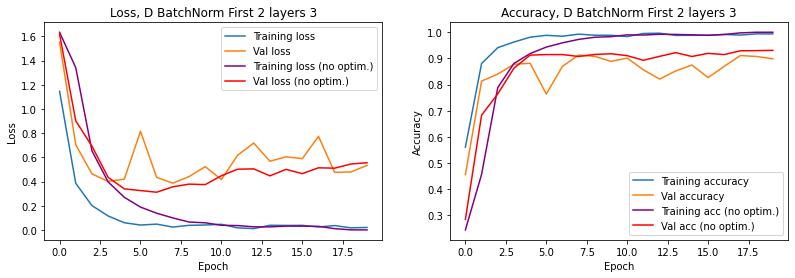

In [55]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyDbatchFIRST1 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDbatchFIRST1,'D BatchNorm First 2 layers '+str(i), historyDvgg4)
    elif i ==2:
        historyDbatchFIRST2 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDbatchFIRST2,'D BatchNorm First 2 layers '+str(i), historyDvgg4)   
    else:
        historyDbatchFIRST3 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDbatchFIRST3,'D BatchNorm First 2 layers '+str(i), historyDvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [59]:
historyDbatchFIRST2.history['val_accuracy'][-1]

0.9510416388511658

In [60]:
historyDbatchFIRST2.history['val_loss'][-1]

0.47380027174949646

###### **-2 last layers**

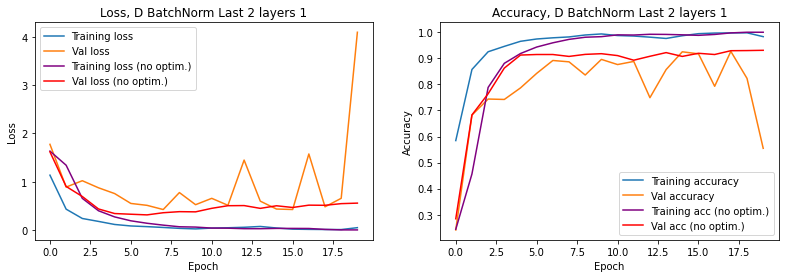

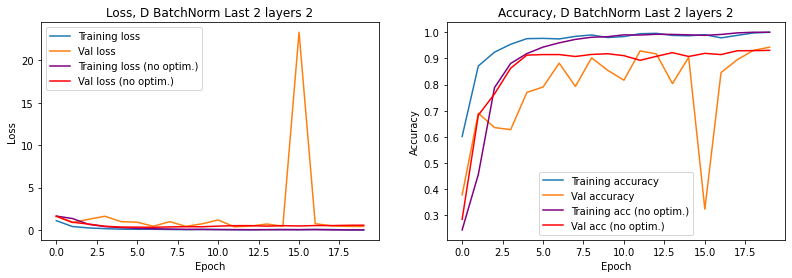

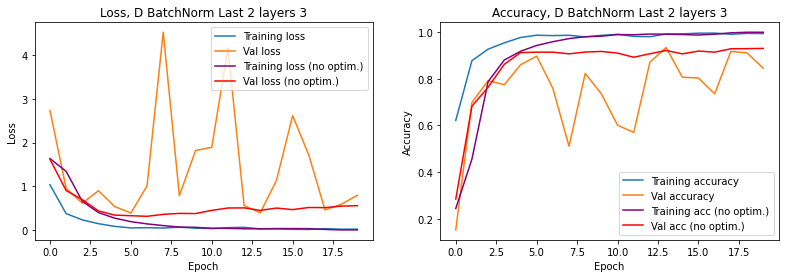

In [58]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyDbatchLAST1 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDbatchLAST1,'D BatchNorm Last 2 layers '+str(i), historyDvgg4)
    elif i ==2:
        historyDbatchLAST2 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDbatchLAST2,'D BatchNorm Last 2 layers '+str(i), historyDvgg4)   
    else:
        historyDbatchLAST3 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDbatchLAST3,'D BatchNorm Last 2 layers '+str(i), historyDvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [63]:
historyDbatchLAST2.history['val_accuracy'][-1]

0.9427083134651184

In [64]:
historyDbatchLAST2.history['val_loss'][-1]

0.41255050897598267

###### **-all 4 layers**

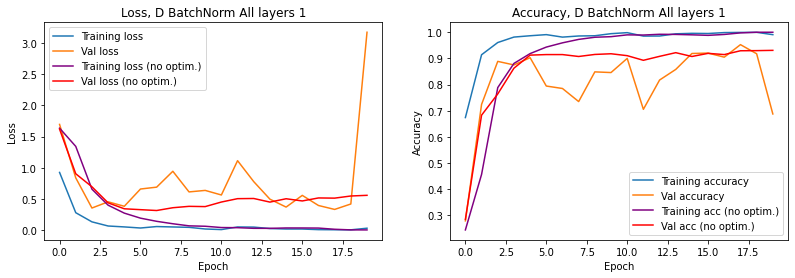

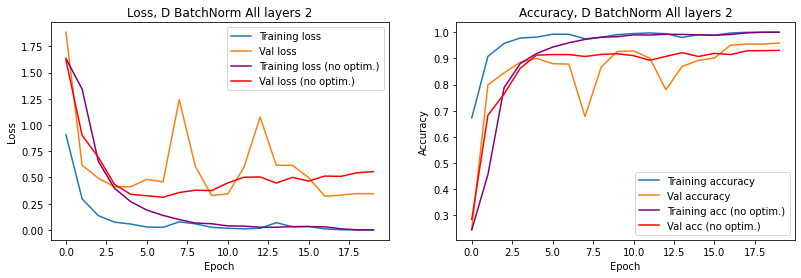

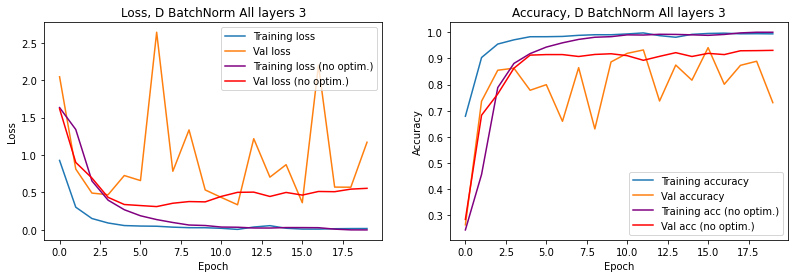

In [57]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    if i == 1:
        historyDbatchALL1 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDbatchALL1,'D BatchNorm All layers '+str(i), historyDvgg4)
    elif i ==2:
        historyDbatchALL2 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDbatchALL2,'D BatchNorm All layers '+str(i), historyDvgg4)   
    else:
        historyDbatchALL3 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDbatchALL3,'D BatchNorm All layers '+str(i), historyDvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [61]:
historyDbatchALL2.history['val_accuracy'][-1]

0.9588541388511658

In [62]:
historyDbatchALL2.history['val_loss'][-1]

0.3446910083293915

##### **Learning rates**

###### **0.001**

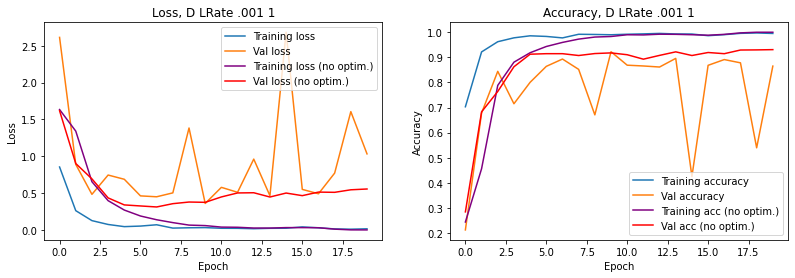

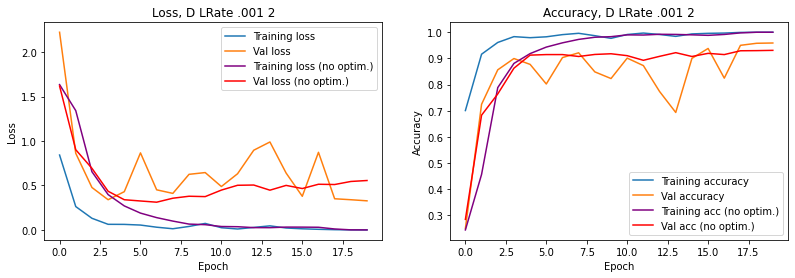

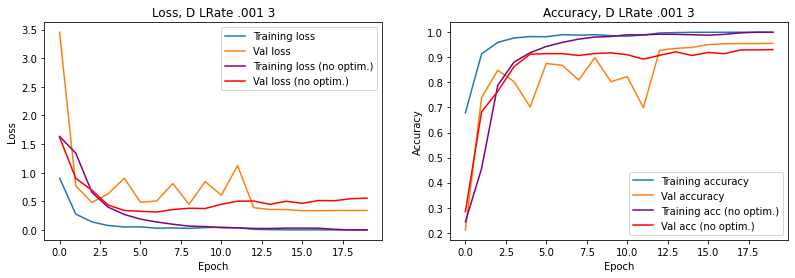

In [76]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    if i == 1:
        historyDlearning1_1 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDlearning1_1,'D LRate .001 '+str(i), historyDvgg4)
    elif i ==2:
        historyDlearning1_2 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDlearning1_2,'D LRate .001 '+str(i), historyDvgg4)   
    else:
        historyDlearning1_3 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDlearning1_3,'D LRate .001 '+str(i), historyDvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [116]:
historyDlearning1_2.history['val_accuracy'][-1]

0.9588541388511658

In [117]:
historyDlearning1_2.history['val_loss'][-1]

0.32726046442985535

###### **0.0008**

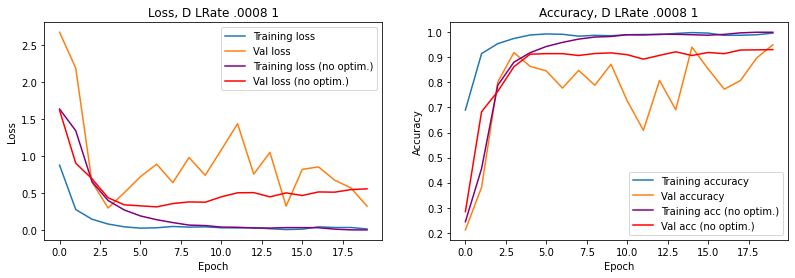

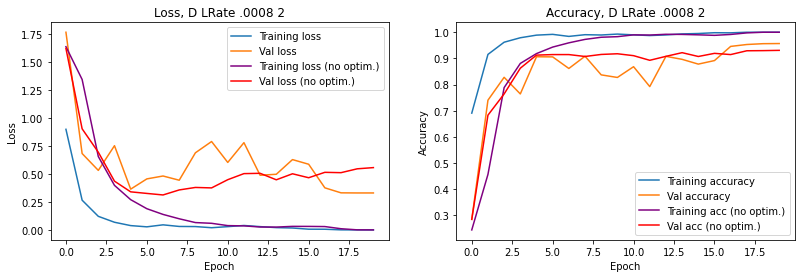

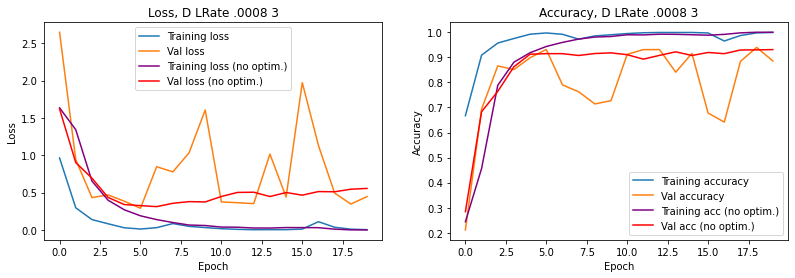

In [77]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    if i == 1:
        historyDlearning08_1 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDlearning08_1,'D LRate .0008 '+str(i), historyDvgg4)
    elif i ==2:
        historyDlearning08_2 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDlearning08_2,'D LRate .0008 '+str(i), historyDvgg4)   
    else:
        historyDlearning08_3 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDlearning08_3,'D LRate .0008 '+str(i), historyDvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [118]:
historyDlearning08_2.history['val_accuracy'][-1]

0.9567708373069763

In [119]:
historyDlearning08_2.history['val_loss'][-1]

0.32973718643188477

###### **0.0005**

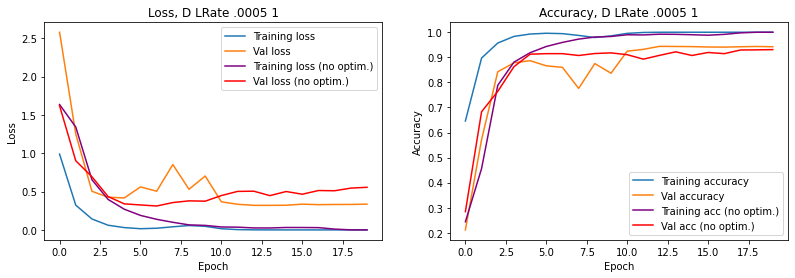

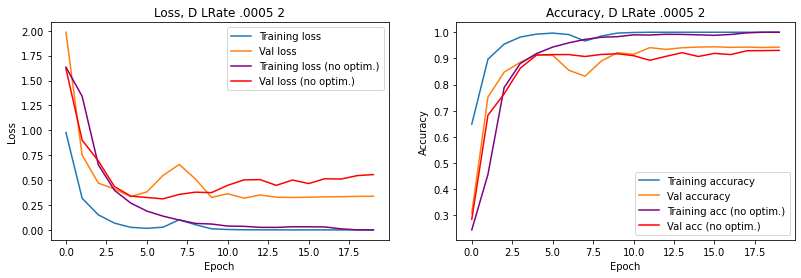

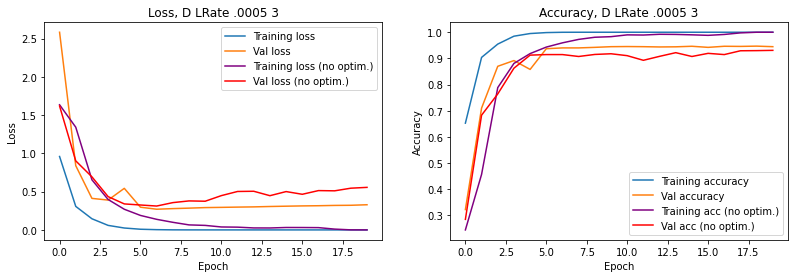

In [123]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    if i == 1:
        historyDlearning05_1 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDlearning05_1,'D LRate .0005 '+str(i), historyDvgg4)
    elif i ==2:
        historyDlearning05_2 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDlearning05_2,'D LRate .0005 '+str(i), historyDvgg4)   
    else:
        historyDlearning05_3 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=20, verbose=0)
        plots(historyDlearning05_3,'D LRate .0005 '+str(i), historyDvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [128]:
historyDlearning05_3.history['val_accuracy'][-1]

0.9447916746139526

In [130]:
historyDlearning05_3.history['val_loss'][-1]

0.32879817485809326

##### **Dropout 0,5**

###### **First 2 layers**

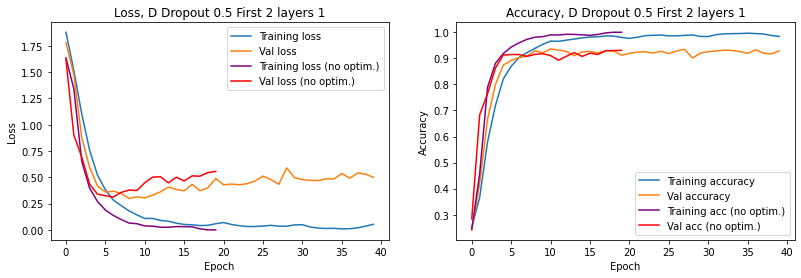

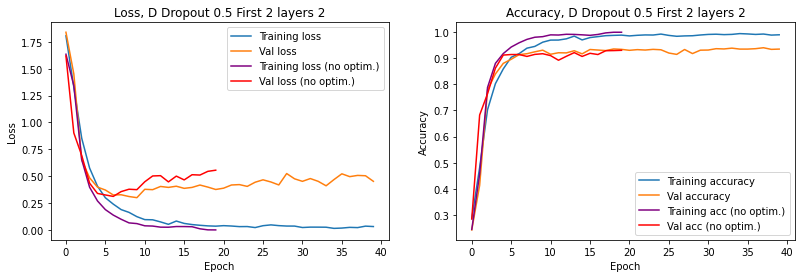

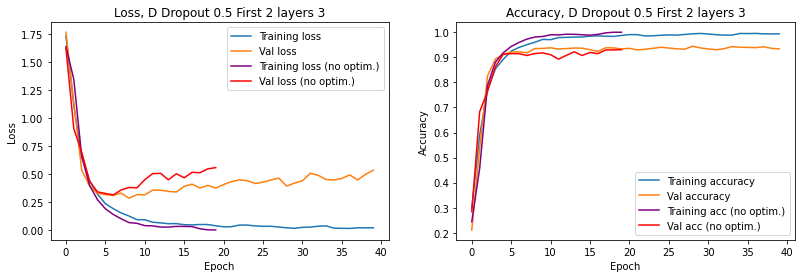

In [137]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyDdropFIRST1 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=40, verbose=0)
        plots(historyDdropFIRST1,'D Dropout 0.5 First 2 layers '+str(i), historyDvgg4)
    elif i ==2:
        historyDdropFIRST2 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=40, verbose=0)
        plots(historyDdropFIRST2,'D Dropout 0.5 First 2 layers '+str(i), historyDvgg4)   
    else:
        historyDdropFIRST3 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=40, verbose=0)
        plots(historyDdropFIRST3,'D Dropout 0.5 First 2 layers '+str(i), historyDvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [169]:
historyDdropFIRST2.history['val_accuracy'][-1]

0.9354166388511658

In [170]:
historyDdropFIRST2.history['val_loss'][-1]

0.4522238075733185

###### **Last 2 layers**

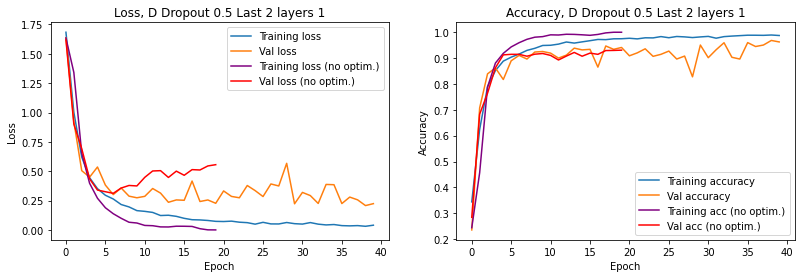

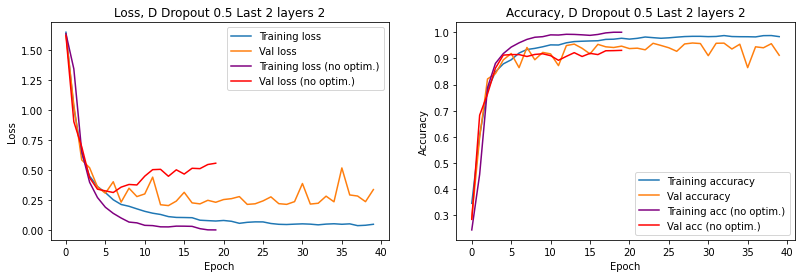

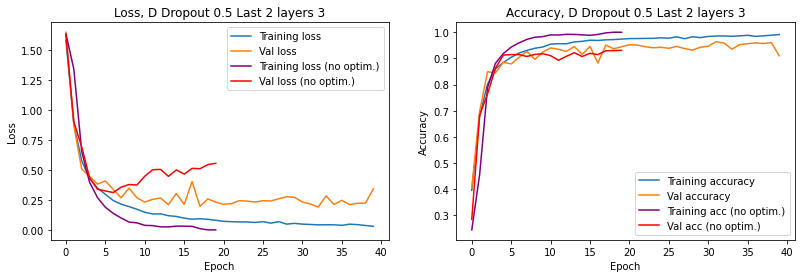

In [138]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyDdropLAST1 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=40, verbose=0)
        plots(historyDdropLAST1,'D Dropout 0.5 Last 2 layers '+str(i), historyDvgg4)
    elif i ==2:
        historyDdropLAST2 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=40, verbose=0)
        plots(historyDdropLAST2,'D Dropout 0.5 Last 2 layers '+str(i), historyDvgg4)   
    else:
        historyDdropLAST3 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=40, verbose=0)
        plots(historyDdropLAST3,'D Dropout 0.5 Last 2 layers '+str(i), historyDvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [171]:
historyDdropLAST1.history['val_accuracy'][-1]

0.9624999761581421

In [172]:
historyDdropLAST1.history['val_loss'][-1]

0.22397831082344055

###### **All layers**

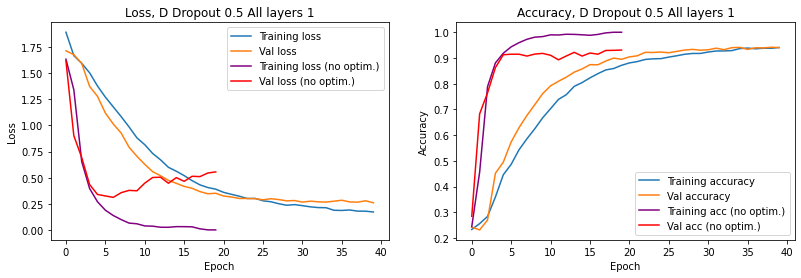

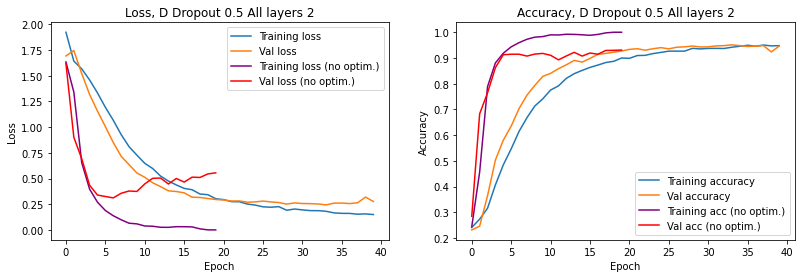

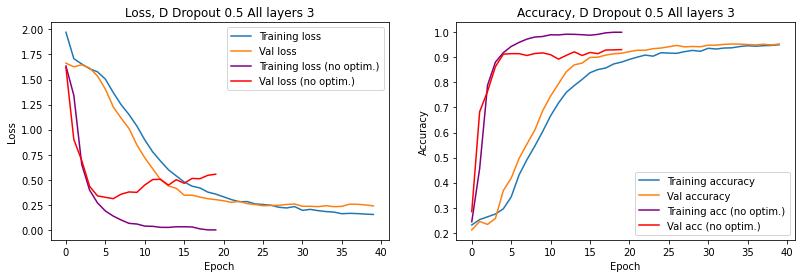

In [139]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyDdropALL1 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=40, verbose=0)
        plots(historyDdropALL1,'D Dropout 0.5 All layers '+str(i), historyDvgg4)
    elif i ==2:
        historyDdropALL2 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=40, verbose=0)
        plots(historyDdropALL2,'D Dropout 0.5 All layers '+str(i), historyDvgg4)   
    else:
        historyDdropALL3 = model.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=40, verbose=0)
        plots(historyDdropALL3,'D Dropout 0.5 All layers '+str(i), historyDvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [175]:
historyDdropALL3.history['val_accuracy'][-1]

0.953125

In [176]:
historyDdropALL3.history['val_loss'][-1]

0.2404295802116394

##### **Early stopping**

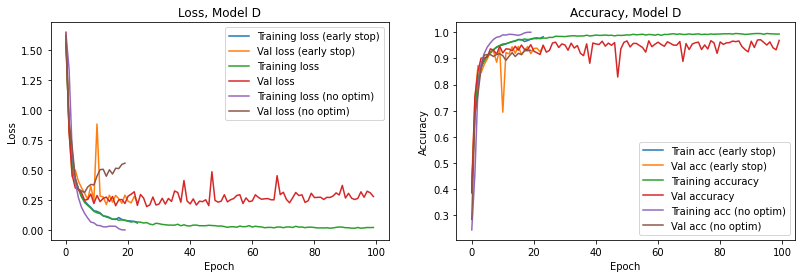

In [225]:
 ### with early stop
model_D_stop = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model_D_stop.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history_D_stop = model_D_stop.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=100, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

 ### withOUT early stop
model_D_no_stop = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model_D_no_stop.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history_D_no_stop = model_D_no_stop.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=100, verbose=0,)

##############################################################

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history_D_stop.history['loss'], label='Training loss (early stop)')
ax.plot(history_D_stop.history['val_loss'], label = 'Val loss (early stop)')
ax.plot(history_D_no_stop.history['loss'], label='Training loss')
ax.plot(history_D_no_stop.history['val_loss'], label = 'Val loss')
ax.plot(historyDvgg4.history['loss'], label='Training loss (no optim)')
ax.plot(historyDvgg4.history['val_loss'], label = 'Val loss (no optim)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model D')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_D_stop.history['accuracy'], label='Train acc (early stop)')
ax.plot(history_D_stop.history['val_accuracy'], label = 'Val acc (early stop)')
ax.plot(history_D_no_stop.history['accuracy'], label='Training accuracy')
ax.plot(history_D_no_stop.history['val_accuracy'],  label = 'Val accuracy')
ax.plot(historyDvgg4.history['accuracy'], label='Training acc (no optim)')
ax.plot(historyDvgg4.history['val_accuracy'], label = 'Val acc (no optim)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model D')

plt.show()

Measuring validation accuracy and loss on model with early stopping:

In [226]:
history_D_stop.history['val_accuracy'][-1]

0.9479166865348816

In [227]:
history_D_stop.history['val_loss'][-1]

0.23252330720424652

Measuring validation accuracy and loss on model without early stopping:

In [228]:
history_D_no_stop.history['val_accuracy'][-1]

0.96875

In [229]:
historyDvgg4.history['val_accuracy'][-1]

0.9307291507720947

#### **Model Y**

##### **Saving a history object for the base VGG4 model**

In [33]:
modelY = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

modelY.compile(
    optimizer='adam',
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

historyYvgg4 = modelY.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)

Measuring models validation accuracy and loss

In [34]:
historyYvgg4.history['val_accuracy'][-1]

0.846875011920929

In [35]:
historyYvgg4.history['val_loss'][-1]

1.082339882850647

##### **Batch normalization**

###### **-2 first layers**

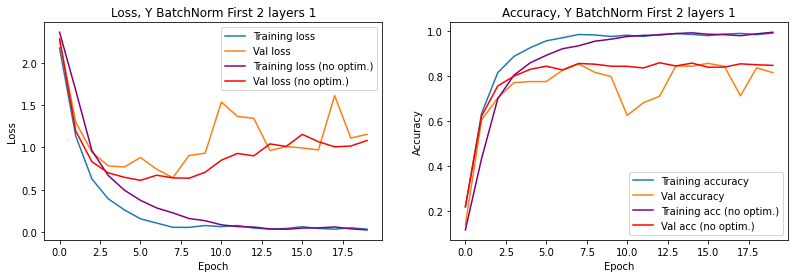

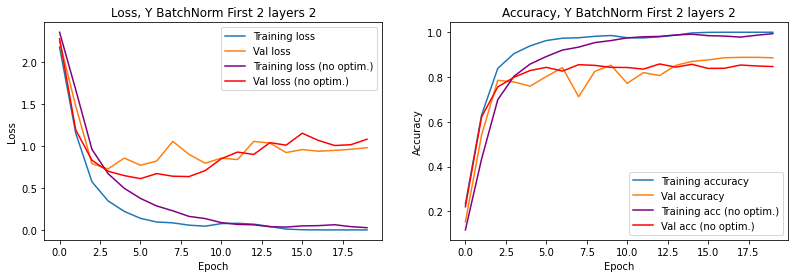

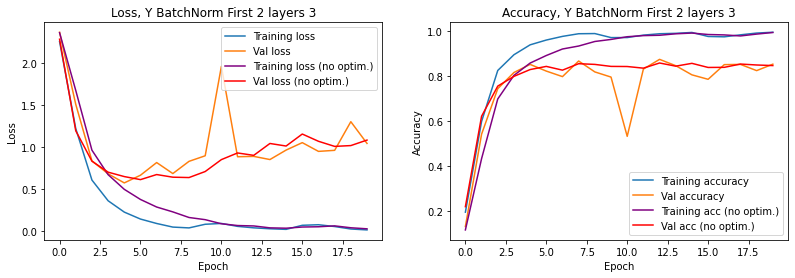

In [41]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyYbatchFIRST1 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYbatchFIRST1,'Y BatchNorm First 2 layers '+str(i), historyYvgg4)
    elif i ==2:
        historyYbatchFIRST2 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYbatchFIRST2,'Y BatchNorm First 2 layers '+str(i), historyYvgg4)   
    else:
        historyYbatchFIRST3 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYbatchFIRST3,'Y BatchNorm First 2 layers '+str(i), historyYvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [46]:
historyYbatchFIRST2.history['val_accuracy'][-1]

0.885937511920929

In [47]:
historyYbatchFIRST2.history['val_loss'][-1]

0.9817343950271606

###### **-2 last layers**

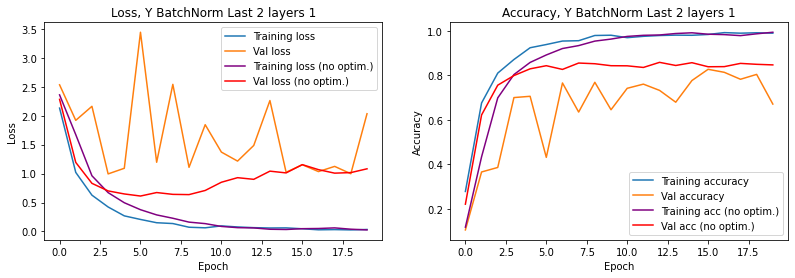

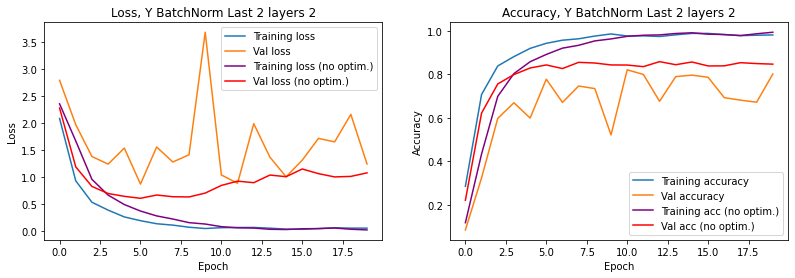

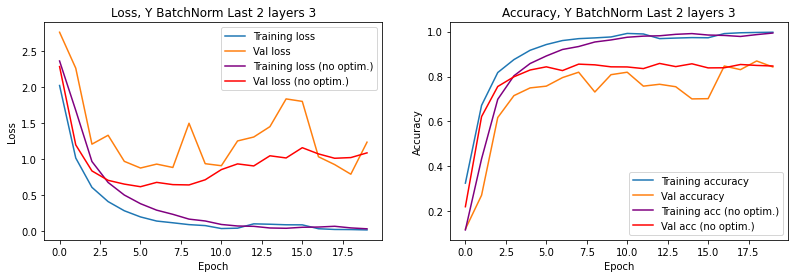

In [39]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyYbatchLAST1 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYbatchLAST1,'Y BatchNorm Last 2 layers '+str(i), historyYvgg4)
    elif i ==2:
        historyYbatchLAST2 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYbatchLAST2,'Y BatchNorm Last 2 layers '+str(i), historyYvgg4)   
    else:
        historyYbatchLAST3 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYbatchLAST3,'Y BatchNorm Last 2 layers '+str(i), historyYvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [42]:
historyYbatchLAST3.history['val_accuracy'][-1]

0.8427083492279053

In [43]:
historyYbatchLAST3.history['val_loss'][-1]

1.2308852672576904

###### **-all 4 layers**

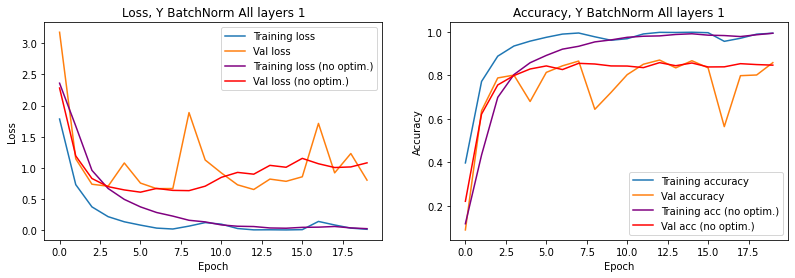

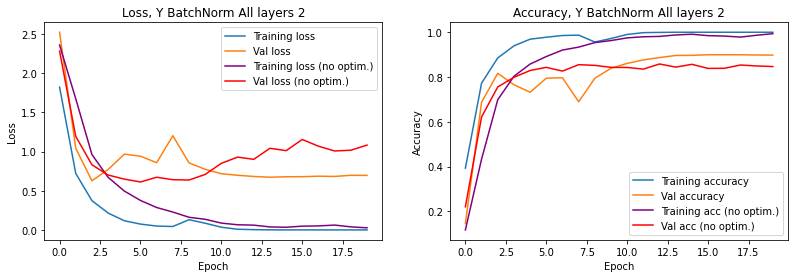

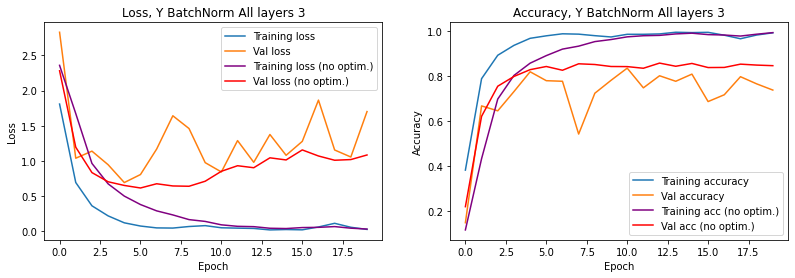

In [38]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer='adam',
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    if i == 1:
        historyYbatchALL1 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYbatchALL1,'Y BatchNorm All layers '+str(i), historyYvgg4)
    elif i ==2:
        historyYbatchALL2 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYbatchALL2,'Y BatchNorm All layers '+str(i), historyYvgg4)   
    else:
        historyYbatchALL3 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYbatchALL3,'Y BatchNorm All layers '+str(i), historyYvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [44]:
historyYbatchALL2.history['val_accuracy'][-1]

0.8979166746139526

In [45]:
historyYbatchALL2.history['val_loss'][-1]

0.6955239176750183

##### **Learning rates**

###### **0.001**

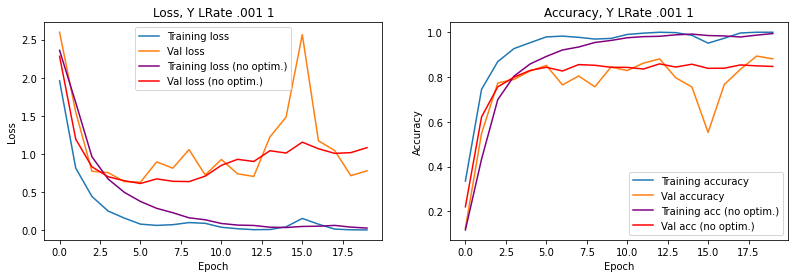

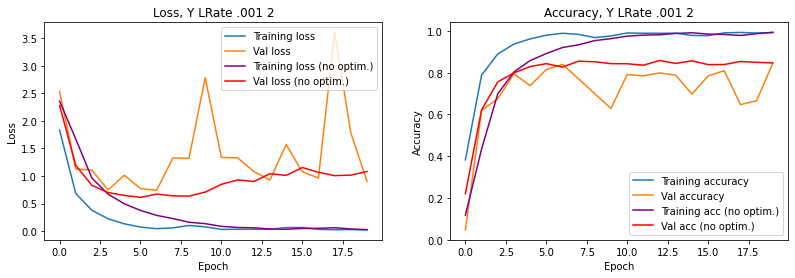

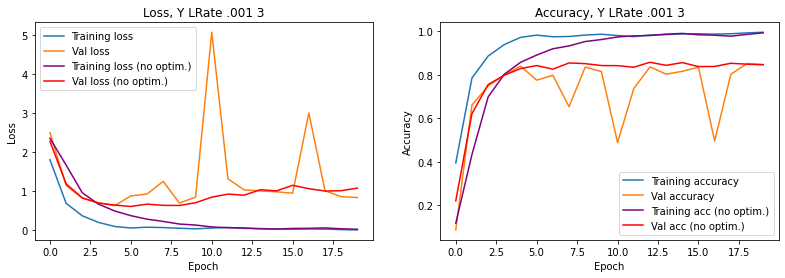

In [73]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    if i == 1:
        historyYlearning1_1 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYlearning1_1,'Y LRate .001 '+str(i), historyYvgg4)
    elif i ==2:
        historyYlearning1_2 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYlearning1_2,'Y LRate .001 '+str(i), historyYvgg4)   
    else:
        historyYlearning1_3 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYlearning1_3,'Y LRate .001 '+str(i), historyYvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [95]:
historyYlearning1_1.history['val_accuracy'][-1]

0.8807291388511658

In [96]:
historyYlearning1_1.history['val_loss'][-1]

0.7788426876068115

###### **0.0008**

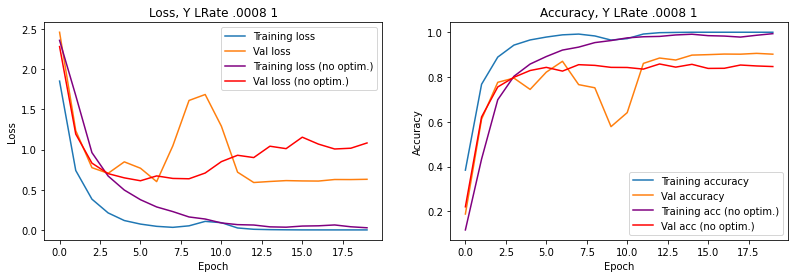

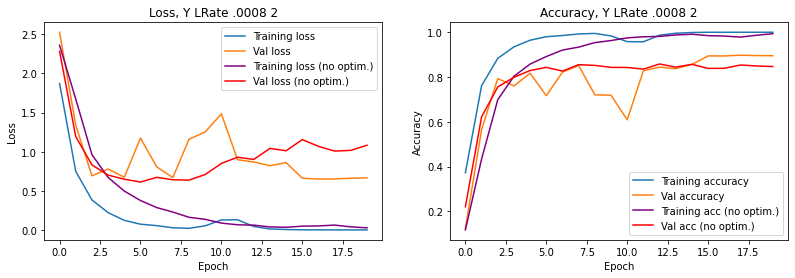

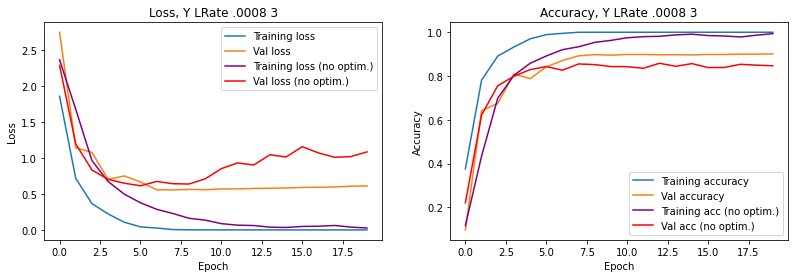

In [105]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    if i == 1:
        historyYlearning08_1 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYlearning08_1,'Y LRate .0008 '+str(i), historyYvgg4)
    elif i ==2:
        historyYlearning08_2 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYlearning08_2,'Y LRate .0008 '+str(i), historyYvgg4)   
    else:
        historyYlearning08_3 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYlearning08_3,'Y LRate .0008 '+str(i), historyYvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [112]:
historyYlearning08_1.history['val_accuracy'][-1]

0.9020833373069763

In [113]:
historyYlearning08_1.history['val_loss'][-1]

0.6301223635673523

###### **0.0005**

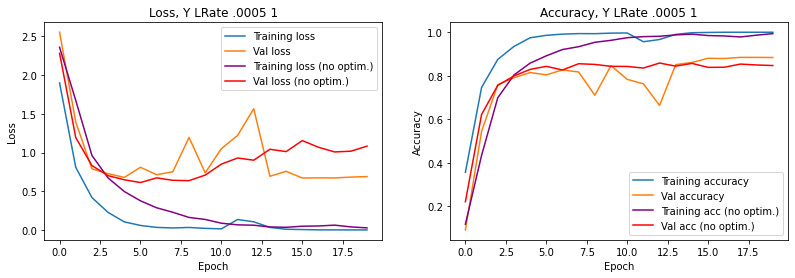

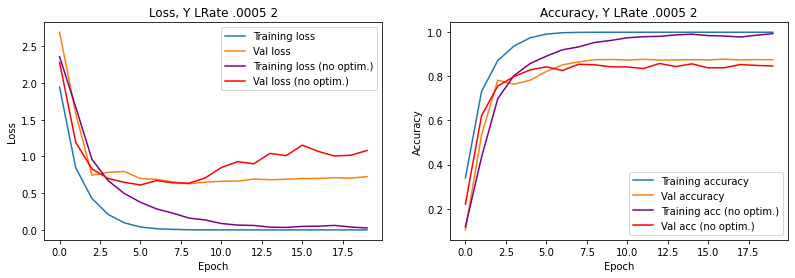

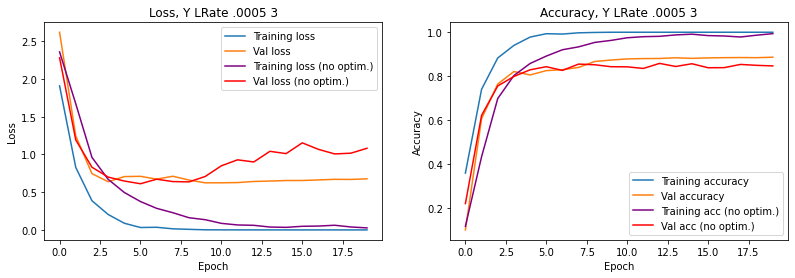

In [101]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 


    if i == 1:
        historyYlearning05_1 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYlearning05_1,'Y LRate .0005 '+str(i), historyYvgg4)
    elif i ==2:
        historyYlearning05_2 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYlearning05_2,'Y LRate .0005 '+str(i), historyYvgg4)   
    else:
        historyYlearning05_3 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=20, verbose=0)
        plots(historyYlearning05_3,'Y LRate .0005 '+str(i), historyYvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [114]:
historyYlearning05_3.history['val_accuracy'][-1]

0.8864583373069763

In [115]:
historyYlearning05_3.history['val_loss'][-1]

0.6771371960639954

##### **Dropout 0,5**

###### **First 2 layers**

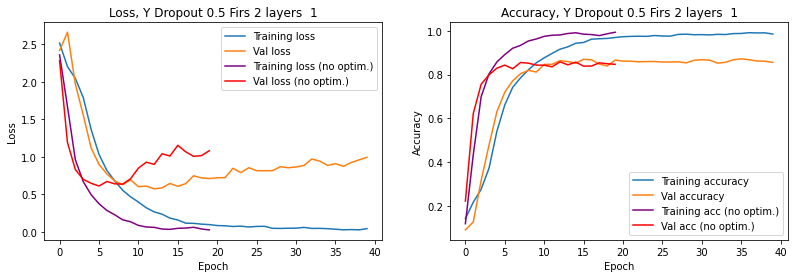

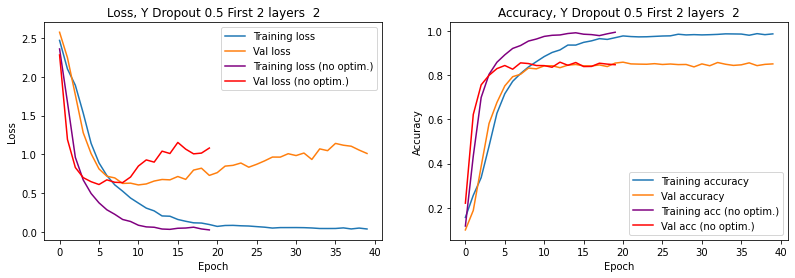

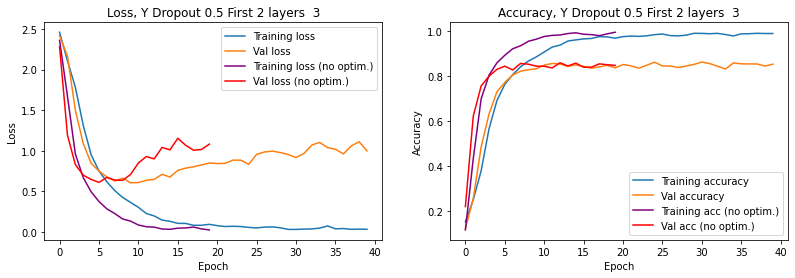

In [134]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyYdropFIRST1 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=40, verbose=0)
        plots(historyYdropFIRST1,'Y Dropout 0.5 Firs 2 layers  '+str(i), historyYvgg4)
    elif i ==2:
        historyYdropFIRST2 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=40, verbose=0)
        plots(historyYdropFIRST2,'Y Dropout 0.5 First 2 layers  '+str(i), historyYvgg4)   
    else:
        historyYdropFIRST3 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=40, verbose=0)
        plots(historyYdropFIRST3,'Y Dropout 0.5 First 2 layers  '+str(i), historyYvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [155]:
historyYdropFIRST1.history['val_accuracy'][-1]

0.8557291626930237

In [156]:
historyYdropFIRST1.history['val_loss'][-1]

0.9938110113143921

###### **Last 2 layers**

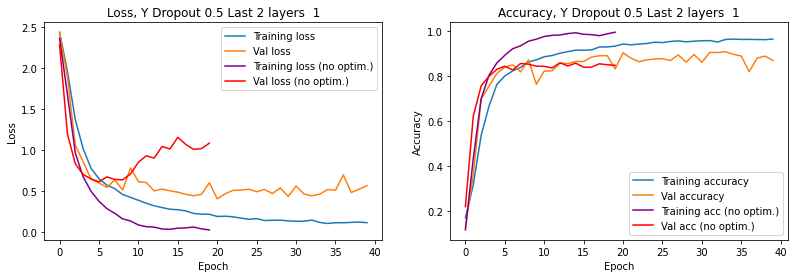

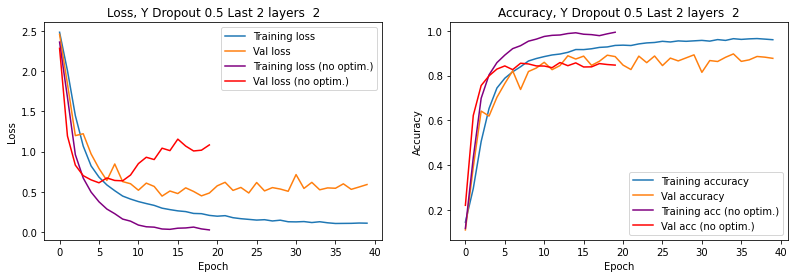

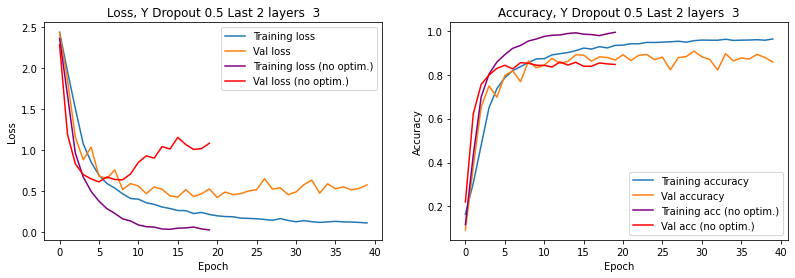

In [135]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        #tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyYdropLAST1 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=40, verbose=0)
        plots(historyYdropLAST1,'Y Dropout 0.5 Last 2 layers  '+str(i), historyYvgg4)
    elif i ==2:
        historyYdropLAST2 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=40, verbose=0)
        plots(historyYdropLAST2,'Y Dropout 0.5 Last 2 layers  '+str(i), historyYvgg4)   
    else:
        historyYdropLAST3 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=40, verbose=0)
        plots(historyYdropLAST3,'Y Dropout 0.5 Last 2 layers  '+str(i), historyYvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [161]:
historyYdropLAST2.history['val_accuracy'][-1]

0.8770833611488342

In [162]:
historyYdropLAST2.history['val_loss'][-1]

0.5904884338378906

###### **All layers**

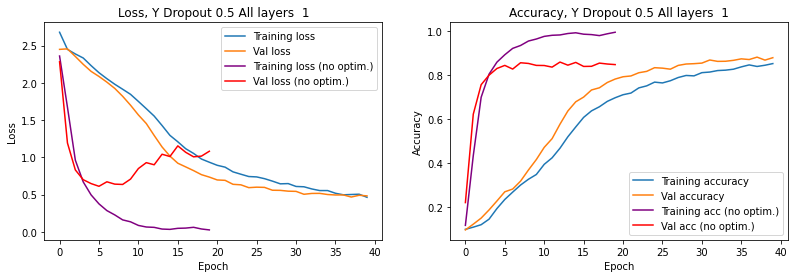

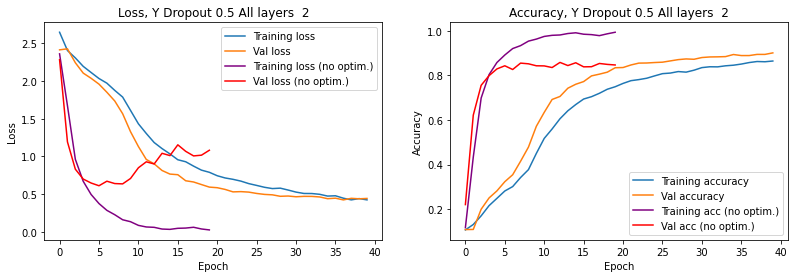

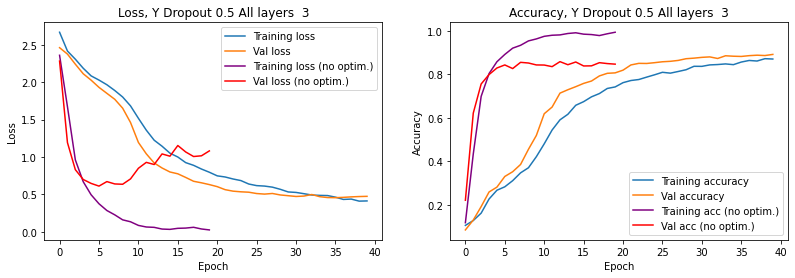

In [136]:
i = 1
while i < 4:
    model = tf.keras.models.Sequential([
        #Block 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 2
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 3
        tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        #Block 4
        tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
        tf.keras.layers.SpatialDropout2D(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(11, activation='softmax'),
        ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy'],
        ) 

    if i == 1:
        historyYdropALL1 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=40, verbose=0)
        plots(historyYdropALL1,'Y Dropout 0.5 All layers  '+str(i), historyYvgg4)
    elif i ==2:
        historyYdropALL2 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=40, verbose=0)
        plots(historyYdropALL2,'Y Dropout 0.5 All layers  '+str(i), historyYvgg4)   
    else:
        historyYdropALL3 = model.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=40, verbose=0)
        plots(historyYdropALL3,'Y Dropout 0.5 All layers  '+str(i), historyYvgg4)
        
    i += 1

Assessing best duplicates validation accuracy and loss:

In [165]:
historyYdropALL2.history['val_accuracy'][-1]

0.9010416865348816

In [166]:
historyYdropALL2.history['val_loss'][-1]

0.44380703568458557

##### **Early stopping**

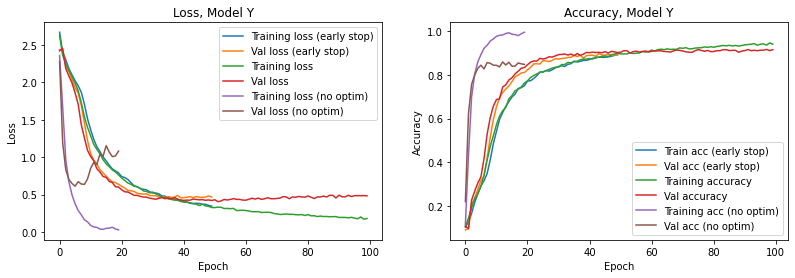

In [208]:
 ### with early stop
model_Y_stop = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model_Y_stop.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history_Y_stop = model_Y_stop.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=100, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

 ### withOUT early stop
model_Y_no_stop = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model_Y_no_stop.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history_Y_no_stop = model_Y_no_stop.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=100, verbose=0,)

##############################################################

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history_Y_stop.history['loss'], label='Training loss (early stop)')
ax.plot(history_Y_stop.history['val_loss'], label = 'Val loss (early stop)')
ax.plot(history_Y_no_stop.history['loss'], label='Training loss')
ax.plot(history_Y_no_stop.history['val_loss'], label = 'Val loss')
ax.plot(historyYvgg4.history['loss'], label='Training loss (no optim)')
ax.plot(historyYvgg4.history['val_loss'], label = 'Val loss (no optim)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model Y')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_Y_stop.history['accuracy'], label='Train acc (early stop)')
ax.plot(history_Y_stop.history['val_accuracy'], label = 'Val acc (early stop)')
ax.plot(history_Y_no_stop.history['accuracy'], label='Training accuracy')
ax.plot(history_Y_no_stop.history['val_accuracy'],  label = 'Val accuracy')
ax.plot(historyYvgg4.history['accuracy'], label='Training acc (no optim)')
ax.plot(historyYvgg4.history['val_accuracy'], label = 'Val acc (no optim)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model Y')

plt.show()


Assessing model validation accuracy and loss with early stopping:

In [219]:
history_Y_stop.history['val_accuracy'][-1]

0.8911458253860474

In [224]:
history_Y_stop.history['val_loss'][-1]

0.46761554479599

Assessing model validation accuracy and loss without early stopping:

In [220]:
history_Y_no_stop.history['val_accuracy'][-1]

0.9140625

In [221]:
historyYvgg4.history['val_accuracy'][-1]

0.846875011920929

### C: data augmentation

#### Data augmentation layer

The data augmentation layer that will be incorporated in all VGG4 models.

In [41]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.03, input_shape=(56, 106, 1))
    ])

#### Visualizing data augmentations effects

Visualizing the effect of the data augmentation layer in being able to angle images up to 29 degrees. 

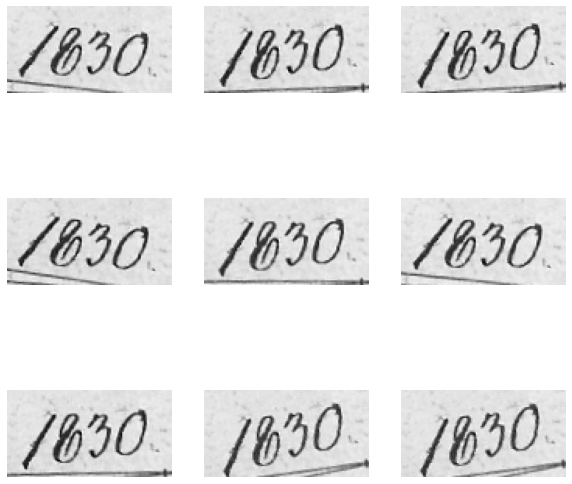

In [12]:
image_aug = x_train.copy()
plt.figure(figsize=(10, 10))
for i in range(9):
    augim = data_augmentation(image_aug, training=True)[0] 
    ax = plt.subplot(3, 3, i + 1); plt.axis('off'); plt.imshow(augim, cmap = 'gray')

#### Model CC, with and without augmentation

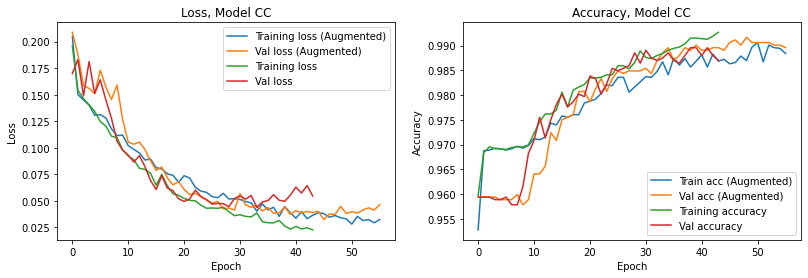

In [34]:
### With Augmentation
model_CC_aug = tf.keras.models.Sequential([
    data_augmentation,
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

model_CC_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'binary_crossentropy',
    metrics=['accuracy'],
    ) 

history_CC_aug = model_CC_aug.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=100, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

### WithOUT Augmentation
model_CC_no_aug = tf.keras.models.Sequential([

    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

model_CC_no_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'binary_crossentropy',
    metrics=['accuracy'],
    ) 

history_CC_no_aug = model_CC_no_aug.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=100, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

############################

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history_CC_aug.history['loss'], label='Training loss (Augmented)')
ax.plot(history_CC_aug.history['val_loss'], label = 'Val loss (Augmented)')
ax.plot(history_CC_no_aug.history['loss'], label='Training loss')
ax.plot(history_CC_no_aug.history['val_loss'], label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model CC')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_CC_aug.history['accuracy'], label='Train acc (Augmented)')
ax.plot(history_CC_aug.history['val_accuracy'], label = 'Val acc (Augmented)')
ax.plot(history_CC_no_aug.history['accuracy'], label='Training accuracy')
ax.plot(history_CC_no_aug.history['val_accuracy'],  label = 'Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model CC')

plt.show()


Augmented model accuracy on valdiation:

In [35]:
history_CC_aug.history['val_accuracy'][-1]

0.9895833134651184

Augmented model loss on valdiation:

In [36]:
history_CC_aug.history['val_loss'][-1]

0.046525485813617706

Un-augmented model accuracy on valdiation:

In [37]:
history_CC_no_aug.history['val_accuracy'][-1]

0.9869791865348816

Un-augmented model loss on valdiation:

In [38]:
history_CC_no_aug.history['val_loss'][-1]

0.05468529462814331

Save the augmented model. (commented out, preventing overwrite)

In [238]:
#model_CC_aug.save('models/CC_CNN_Final.h5')

#### Model D, with and without augmentation

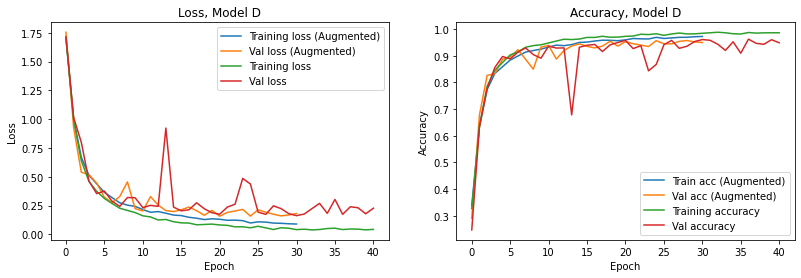

In [13]:
### With Augmentation
model_D_aug = tf.keras.models.Sequential([
    data_augmentation,
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model_D_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history_D_aug = model_D_aug.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=100, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

### WithOUT Augmentation
model_D_no_aug = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model_D_no_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )

history_D_no_aug = model_D_no_aug.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=100, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

############################

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history_D_aug.history['loss'], label='Training loss (Augmented)')
ax.plot(history_D_aug.history['val_loss'], label = 'Val loss (Augmented)')
ax.plot(history_D_no_aug.history['loss'], label='Training loss')
ax.plot(history_D_no_aug.history['val_loss'], label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model D')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_D_aug.history['accuracy'], label='Train acc (Augmented)')
ax.plot(history_D_aug.history['val_accuracy'], label = 'Val acc (Augmented)')
ax.plot(history_D_no_aug.history['accuracy'], label='Training accuracy')
ax.plot(history_D_no_aug.history['val_accuracy'],  label = 'Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model D')

plt.show()


Augmented model accuracy on valdiation:

In [18]:
history_D_aug.history['val_accuracy'][-1]

0.9494791626930237

Augmented model loss on valdiation:

In [19]:
history_D_aug.history['val_loss'][-1]

0.180527463555336

Un-augmented model accuracy on valdiation:

In [20]:
history_D_no_aug.history['val_accuracy'][-1]

0.948437511920929

Un-augmented model loss on valdiation:

In [21]:
history_D_no_aug.history['val_loss'][-1]

0.2266274392604828

Save the augmented model. (commented out, preventing overwrite)

In [238]:
#model_D_aug.save('models/D_CNN_Final.h5')

#### Model Y, with and without augmentation

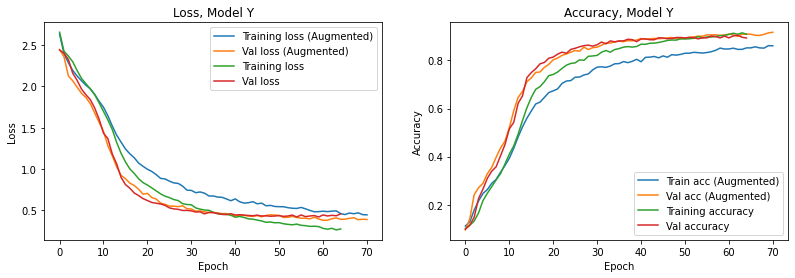

In [29]:
### With Augmentation
model_Y_aug = tf.keras.models.Sequential([
    data_augmentation,
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model_Y_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history_Y_aug = model_Y_aug.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=100, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

### WithOUT Augmentation
model_Y_no_aug = tf.keras.models.Sequential([
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model_Y_no_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history_Y_no_aug = model_Y_no_aug.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=100, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

############################

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history_Y_aug.history['loss'], label='Training loss (Augmented)')
ax.plot(history_Y_aug.history['val_loss'], label = 'Val loss (Augmented)')
ax.plot(history_Y_no_aug.history['loss'], label='Training loss')
ax.plot(history_Y_no_aug.history['val_loss'], label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model Y')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_Y_aug.history['accuracy'], label='Train acc (Augmented)')
ax.plot(history_Y_aug.history['val_accuracy'], label = 'Val acc (Augmented)')
ax.plot(history_Y_no_aug.history['accuracy'], label='Training accuracy')
ax.plot(history_Y_no_aug.history['val_accuracy'],  label = 'Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model Y')

plt.show()


Augmented model accuracy on valdiation:

In [30]:
history_Y_aug.history['val_accuracy'][-1]

0.917187511920929

Augmented model loss on valdiation:

In [31]:
history_Y_aug.history['val_loss'][-1]

0.3898046910762787

Un-augmented model accuracy on valdiation:

In [32]:
history_Y_no_aug.history['val_accuracy'][-1]

0.8932291865348816

Un-augmented model loss on valdiation:

In [33]:
history_Y_no_aug.history['val_loss'][-1]

0.4576628506183624

Save the augmented model. (commented out, preventing overwrite)

In [238]:
#model_Y_aug.save('models/Y_CNN_Final.h5')

### D: transfer learning, VGG16

Transforming train, test and valdiation splits from grayscale to RGB to allow application in the VGG16 transfer model:

In [20]:
x_train_transfer = tf.image.grayscale_to_rgb(tf.constant(x_train))
x_test_transfer = tf.image.grayscale_to_rgb(tf.constant(x_test))
x_val_transfer = tf.image.grayscale_to_rgb(tf.constant(x_val))

#### CC classifier

Initialize transfer model

In [44]:
transfer_model_CC = VGG16(include_top=False, input_shape=(56, 106, 3))
# mark loaded layers as not trainable
for layer in transfer_model_CC.layers:
    layer.trainable = False
# add new classifier layers
flat1 = layers.Flatten()(transfer_model_CC.layers[-1].output)
class1 = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
drop1 = layers.Dropout(0.2)(class1)
output = layers.Dense(1, activation='sigmoid')(drop1)
# define new model
transfer_model_CC = models.Model(inputs=transfer_model_CC.inputs, outputs=output)

transfer_model_CC.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
transfer_model_CC.summary()

NameError: name 'layers' is not defined

Fit the model.

In [ ]:
transfer_history_CC = transfer_model_CC.fit(x_train_transfer,CC_train, 
                                            steps_per_epoch=len(x_train_transfer), 
                                            epochs=50,
                                            validation_data=(x_val_transfer,CC_val), 
                                            validation_steps=len(x_val_transfer), 
                                            callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

Visualize training of the transfer learning models.

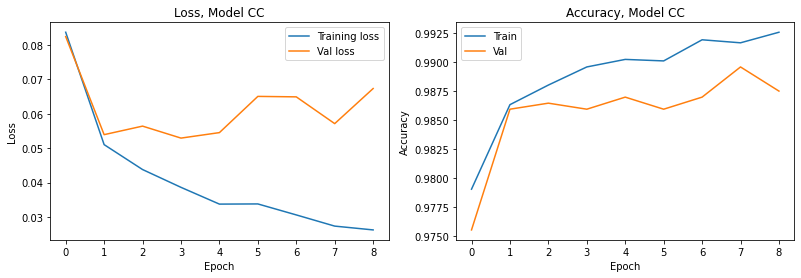

In [32]:
fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(transfer_history_CC.history['loss'], label='Training loss')
ax.plot(transfer_history_CC.history['val_loss'], label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model CC')

ax = fig.add_subplot(1, 2, 2)
ax.plot(transfer_history_CC.history['accuracy'], label='Train')
ax.plot(transfer_history_CC.history['val_accuracy'], label = 'Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model CC')

plt.show()

Evaluate model on the test set.

In [31]:
transfer_model_CC.evaluate(x_test_transfer,CC_test)

75/75 [==============================] - 2s 24ms/step - loss: 0.0615 - accuracy: 0.9833


[0.06154831498861313, 0.9833333492279053]

#### Y Classifier

Initialize transfer model

In [33]:
transfer_model_Y = VGG16(include_top=False, input_shape=(56, 106, 3))
# mark loaded layers as not trainable
for layer in transfer_model_Y.layers:
    layer.trainable = False
# add new classifier layers
flat1 = layers.Flatten()(transfer_model_Y.layers[-1].output)
class1 = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
drop1 = layers.Dropout(0.2)(class1)
output = layers.Dense(11, activation='softmax')(drop1)
# define new model
transfer_model_Y = models.Model(inputs=transfer_model_Y.inputs, outputs=output)

transfer_model_Y.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0008), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
transfer_model_Y.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 56, 106, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 56, 106, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 56, 106, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 28, 53, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 28, 53, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 28, 53, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 14, 26, 128)       0   

Fit the model.

In [34]:
transfer_history_Y = transfer_model_Y.fit(x_train_transfer,Y_train, 
                                            steps_per_epoch=len(x_train_transfer), 
                                            epochs=50,
                                            validation_data=(x_val_transfer,Y_val), 
                                            validation_steps=len(x_val_transfer), 
                                            callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

Epoch 1/50
7680/7680 [==============================] - 65s 8ms/step - loss: 2.0187 - accuracy: 0.2758 - val_loss: 1.7129 - val_accuracy: 0.3974
Epoch 2/50
7680/7680 [==============================] - 65s 8ms/step - loss: 1.6449 - accuracy: 0.4089 - val_loss: 1.4107 - val_accuracy: 0.5297
Epoch 3/50
7680/7680 [==============================] - 62s 8ms/step - loss: 1.4826 - accuracy: 0.4723 - val_loss: 1.3764 - val_accuracy: 0.5281
Epoch 4/50
7680/7680 [==============================] - 64s 8ms/step - loss: 1.4019 - accuracy: 0.5039 - val_loss: 1.3207 - val_accuracy: 0.5385
Epoch 5/50
7680/7680 [==============================] - 65s 8ms/step - loss: 1.3485 - accuracy: 0.5158 - val_loss: 1.2212 - val_accuracy: 0.5932
Epoch 6/50
7680/7680 [==============================] - 66s 9ms/step - loss: 1.2865 - accuracy: 0.5431 - val_loss: 1.2060 - val_accuracy: 0.5849
Epoch 7/50
7680/7680 [==============================] - 63s 8ms/step - loss: 1.2549 - accuracy: 0.5531 - val_loss: 1.1837 - val_ac

Visualize training of the transfer learning models.

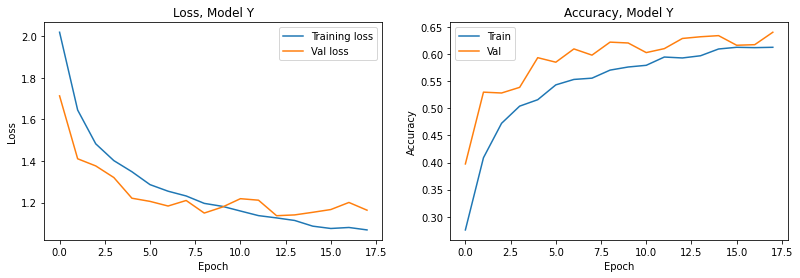

In [36]:
fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(transfer_history_Y.history['loss'], label='Training loss')
ax.plot(transfer_history_Y.history['val_loss'], label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model Y')

ax = fig.add_subplot(1, 2, 2)
ax.plot(transfer_history_Y.history['accuracy'], label='Train')
ax.plot(transfer_history_Y.history['val_accuracy'], label = 'Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model Y')

plt.show()

Evaluate model on the test set.

In [35]:
transfer_model_Y.evaluate(x_test_transfer,Y_test)

75/75 [==============================] - 2s 23ms/step - loss: 1.0634 - accuracy: 0.6662


[1.0634398460388184, 0.6662499904632568]

#### D Classifier


Initialize transfer model

In [26]:
transfer_model_D = VGG16(include_top=False, input_shape=(56, 106, 3))
# mark loaded layers as not trainable
for layer in transfer_model_D.layers:
    layer.trainable = False
# add new classifier layers
flat1 = layers.Flatten()(transfer_model_D.layers[-1].output)
class1 = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
drop1 = layers.Dropout(0.2)(class1)
output = layers.Dense(11, activation='softmax')(drop1)
# define new model
transfer_model_D = models.Model(inputs=transfer_model_D.inputs, outputs=output)

transfer_model_D.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0008), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
transfer_model_D.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 56, 106, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 56, 106, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 56, 106, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 28, 53, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 28, 53, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 28, 53, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 14, 26, 128)       0   

C:\Users\oeste\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Fit the model.

In [24]:
transfer_history_D = transfer_model_D.fit(x_train_transfer,D_train, 
                                            steps_per_epoch=len(x_train_transfer), 
                                            epochs=50,
                                            validation_data=(x_val_transfer,D_val), 
                                            validation_steps=len(x_val_transfer), 
                                            callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

Epoch 1/50
7680/7680 [==============================] - 77s 10ms/step - loss: 1.4446 - accuracy: 0.4020 - val_loss: 1.2281 - val_accuracy: 0.5052
Epoch 2/50
7680/7680 [==============================] - 75s 10ms/step - loss: 1.2405 - accuracy: 0.4954 - val_loss: 1.1389 - val_accuracy: 0.5458
Epoch 3/50
7680/7680 [==============================] - 75s 10ms/step - loss: 1.1703 - accuracy: 0.5232 - val_loss: 1.0896 - val_accuracy: 0.5740
Epoch 4/50
7680/7680 [==============================] - 75s 10ms/step - loss: 1.1466 - accuracy: 0.5335 - val_loss: 1.1466 - val_accuracy: 0.5552
Epoch 5/50
7680/7680 [==============================] - 75s 10ms/step - loss: 1.1179 - accuracy: 0.5531 - val_loss: 1.0454 - val_accuracy: 0.5859
Epoch 6/50
7680/7680 [==============================] - 74s 10ms/step - loss: 1.1247 - accuracy: 0.5454 - val_loss: 1.0916 - val_accuracy: 0.5813
Epoch 7/50
7680/7680 [==============================] - 71s 9ms/step - loss: 1.1056 - accuracy: 0.5535 - val_loss: 1.0977 - 

Visualize training of the transfer learning models.

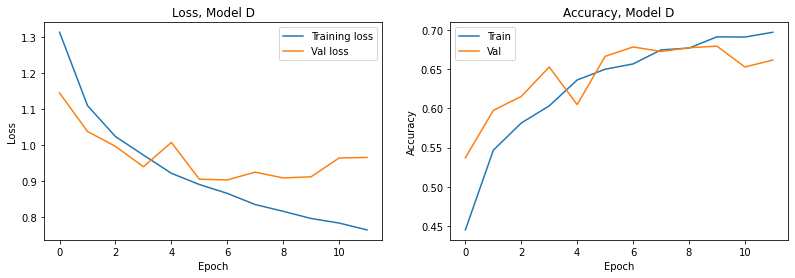

In [40]:
fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(transfer_history_D.history['loss'], label='Training loss')
ax.plot(transfer_history_D.history['val_loss'], label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model D')

ax = fig.add_subplot(1, 2, 2)
ax.plot(transfer_history_D.history['accuracy'], label='Train')
ax.plot(transfer_history_D.history['val_accuracy'], label = 'Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model D')

plt.show()

Evaluate model on the test set.

In [25]:
transfer_model_D.evaluate(x_test_transfer,D_test)

75/75 [==============================] - 14s 134ms/step - loss: 1.0684 - accuracy: 0.6300


[1.0683971643447876, 0.6299999952316284]

### CC revised, 50/50 label balance

Import the VGG16 model.

In [21]:
base = VGG16(include_top=False, input_shape=(56, 106, 3))

Prepare the data augmentation layer used in optimized VGG4 models, converted to RGB.

In [22]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.03, input_shape=(56, 106, 3))
    ])

Compile a model for classifying CC on the base of VGG16. 

In [30]:
transfer_model_CC = tf.keras.models.Sequential()
transfer_model_CC.add(data_augmentation)
transfer_model_CC.add(base)
transfer_model_CC.add(tf.keras.layers.Flatten())
transfer_model_CC.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
transfer_model_CC.add(tf.keras.layers.Dropout(0.2))
transfer_model_CC.add(tf.keras.layers.Dense(1, activation='sigmoid'))
transfer_model_CC.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
transfer_model_CC.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 56, 106, 3)        0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 1, 3, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               196736    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 14,911,553
Trainable params: 14,911,553
Non-trainable params: 0
__________________________________________

Create a history object for the model and train it on the 50/50 training set.

In [31]:
transfer_history_CC = transfer_model_CC.fit(train_5050,train_5050_label,
                                            epochs=50,validation_data=(val_5050,val_5050_label), 
                                            validation_steps=len(val_5050), 
                                            callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

Epoch 1/50
19/19 [==============================] - 1s 46ms/step - loss: 0.7056 - accuracy: 0.5026 - val_loss: 0.7143 - val_accuracy: 0.4545
Epoch 2/50
19/19 [==============================] - 1s 38ms/step - loss: 0.6902 - accuracy: 0.5251 - val_loss: 0.7053 - val_accuracy: 0.4545
Epoch 3/50
19/19 [==============================] - 1s 39ms/step - loss: 0.6957 - accuracy: 0.5130 - val_loss: 0.7058 - val_accuracy: 0.4545
Epoch 4/50
19/19 [==============================] - 1s 38ms/step - loss: 0.7056 - accuracy: 0.4870 - val_loss: 0.6927 - val_accuracy: 0.4545
Epoch 5/50
19/19 [==============================] - 1s 39ms/step - loss: 0.6961 - accuracy: 0.5095 - val_loss: 0.6816 - val_accuracy: 0.4545
Epoch 6/50
19/19 [==============================] - 1s 39ms/step - loss: 0.6808 - accuracy: 0.5217 - val_loss: 0.8472 - val_accuracy: 0.4545
Epoch 7/50
19/19 [==============================] - 1s 39ms/step - loss: 0.6937 - accuracy: 0.5702 - val_loss: 0.6259 - val_accuracy: 0.6566
Epoch 8/50
19

Print validation accuracy and loss for the model.

In [36]:
transfer_model_CC.evaluate(val_5050,val_5050_label)

4/4 [==============================] - 0s 7ms/step - loss: 0.5561 - accuracy: 0.9293


[0.5560500025749207, 0.9292929172515869]

Visualize a confusion matrix on predictions for the validation set.

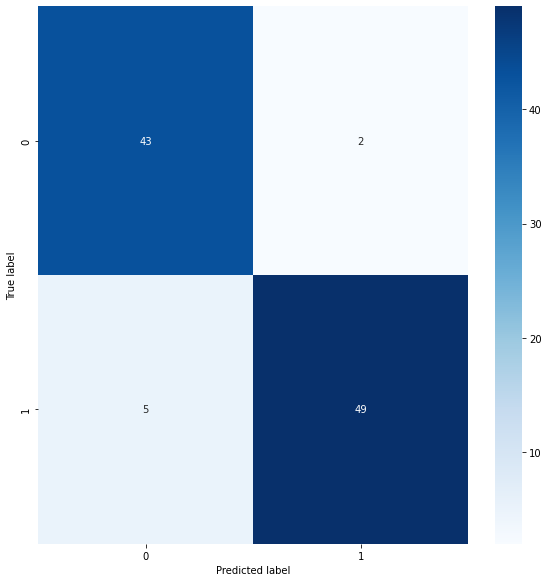

In [41]:
pred_CC = transfer_model_CC.predict(val_5050)
results = []
for i in pred_CC:
    if i < 0.5:
        results.append(0)
    else:
        results.append(1)
matrix = tf.math.confusion_matrix(val_5050_label,results)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(matrix, annot=True,cmap=plt.cm.Blues, fmt='d')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Question 2.3

Please run section "Score Calculators" to import functions for calculating scores. 

The CC model is dependant on 2.2.D "CC revised, 50/50 label balance".

#### Loading optimized VGG4 models from 2.2.C.

In [70]:
loaded_D  = tf.keras.models.load_model('models/D_CNN_Final.h5')
loaded_Y = tf.keras.models.load_model('models/Y_CNN_Final.h5')

Deploying the transfer model on label CC requires for the grayscale test data dor DIDA_12000 and DIDA_30k to be upscaled to RGB. 

Test sets are converted to RGB ans saved on variables.

In [71]:
x_test_RGB = tf.image.grayscale_to_rgb(tf.constant(x_test))
k30_img_RGB = tf.image.grayscale_to_rgb(tf.constant(k30_img_vals))

#### 30k character score

In [72]:
preds = transfer_model_CC.predict(k30_img_RGB)
results = []
for i in preds:
    if i < 0.5:
        results.append(0)
    else:
        results.append(1)
results
test_score_CC = 0.0
i = 0
for row in k30_labels_CC:
    if int(row) == results[i]:
        test_score_CC = test_score_CC + (1/3)
    i= i + 1
print('CC character score on 30k: '+str(test_score_CC))
test_score_D = accuracy_calc(loaded_D,k30_labels_D,k30_img_vals)
test_score_Y = accuracy_calc(loaded_Y,k30_labels_Y,k30_img_vals)
print('D character score on 30k: '+str(test_score_D))
print('Y character score on 30k: '+str(test_score_Y))
character_score_30k = ((test_score_Y+test_score_CC+test_score_D)/len(k30_img_vals))*100
print('Relative collective score in percent: '+str(character_score_30k))

CC character score on 30k: 288.6666666666677
D character score on 30k: 275.33333333333513
Y character score on 30k: 262.6666666666692
Relative collective score in percent: 82.6666666666672


#### Redefining a sequence scoring function for use on transfer and VGG4 models.

In [89]:
def sequence_calc_2_3(model_CC,
                      model_D,
                      model_Y,
                      CC_test,
                      D_test,
                      Y_test,
                      x_test,
                      x_test_RGB):
    preds_D = np.argmax(model_D.predict(x_test),axis = 1)
    preds_Y = np.argmax(model_Y.predict(x_test),axis = 1)
    preds_CC = model_CC.predict(x_test_RGB)
    results_CC = []
    for i in preds_CC:
        if i < 0.5:
            results_CC.append(0)
        else:
            results_CC.append(1)
    CC_array = np.array(CC_test)
    D_array = np.array(D_test)
    Y_array = np.array(Y_test)
    score = 0.0
    i = 0
    while i < len(CC_array):
        if int(CC_array[i]) == results_CC[i]:
            if int(D_array[i]) == preds_D[i]:
                if int(Y_array[i]) == preds_Y[i]:
                    score = score + 1
        i= i + 1
    return score

#### Sequence score 30k

In [90]:
sec_score_30k = sequence_calc_2_3(transfer_model_CC,
                                  loaded_D,
                                  loaded_Y,
                                  k30_labels_CC,
                                  k30_labels_D,
                                  k30_labels_Y,
                                  k30_img_vals,
                                  k30_img_RGB)
sec_score_30k

620.0

## Question 3.1 

The CC model in this chapter is dependant on 2.2.D "CC revised, 50/50 label balance".

#### Loading optimized VGG4 models from 2.2.C.

In [16]:
loaded_D  = tf.keras.models.load_model('models/D_CNN_Final.h5')
loaded_Y = tf.keras.models.load_model('models/Y_CNN_Final.h5')
loaded_CC = tf.keras.models.load_model('models/CC_CNN_Final.h5')

### Feature Maps

Import the image to visualize in all feature maps.

In [80]:
image = x_train[1]
image = image.reshape(1,56,106,1)

#### Model CC

Print layer names.

In [78]:
for i in range(len(loaded_CC.layers)):
    layer = loaded_CC.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

1 conv2d (None, 54, 104, 32)
5 conv2d_1 (None, 25, 50, 64)
9 conv2d_2 (None, 10, 23, 128)
13 conv2d_3 (None, 3, 9, 256)


Visualize layers and save on variables.

In [79]:
visualize_layer0 = tf.keras.Model(inputs=loaded_CC.inputs , outputs=loaded_CC.layers[1].output)
visualize_layer3 = tf.keras.Model(inputs=loaded_CC.inputs , outputs=loaded_CC.layers[5].output)
visualize_layer6 = tf.keras.Model(inputs=loaded_CC.inputs , outputs=loaded_CC.layers[9].output)
visualize_layer9 = tf.keras.Model(inputs=loaded_CC.inputs , outputs=loaded_CC.layers[13].output)

Visualize the first 16 layer outputs in each block.

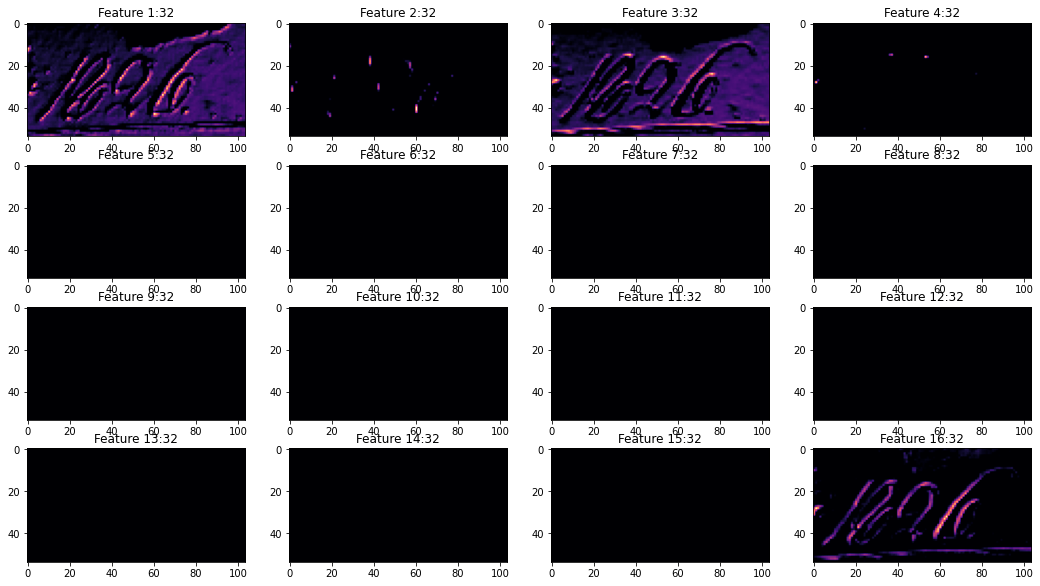

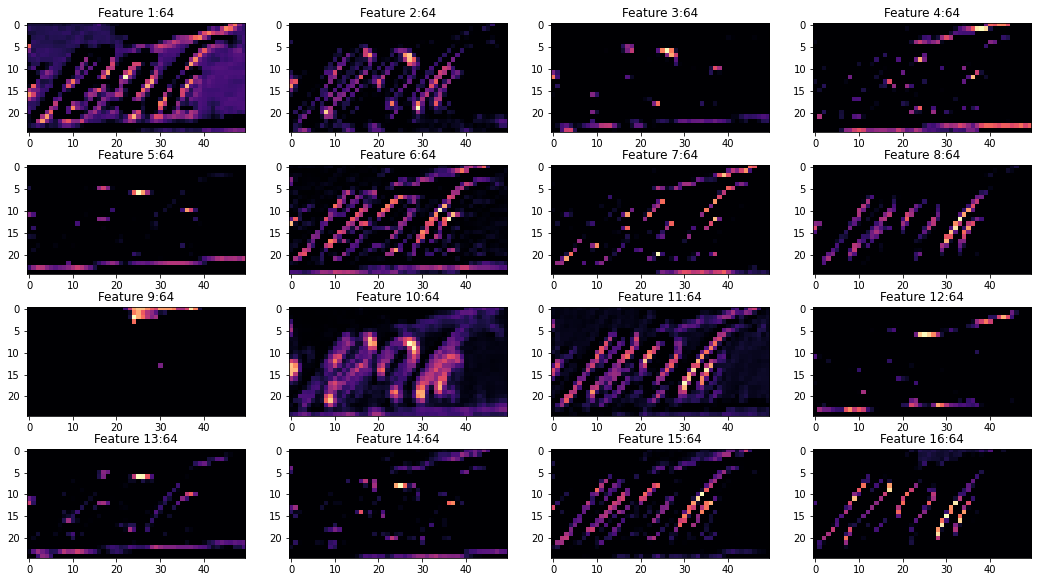

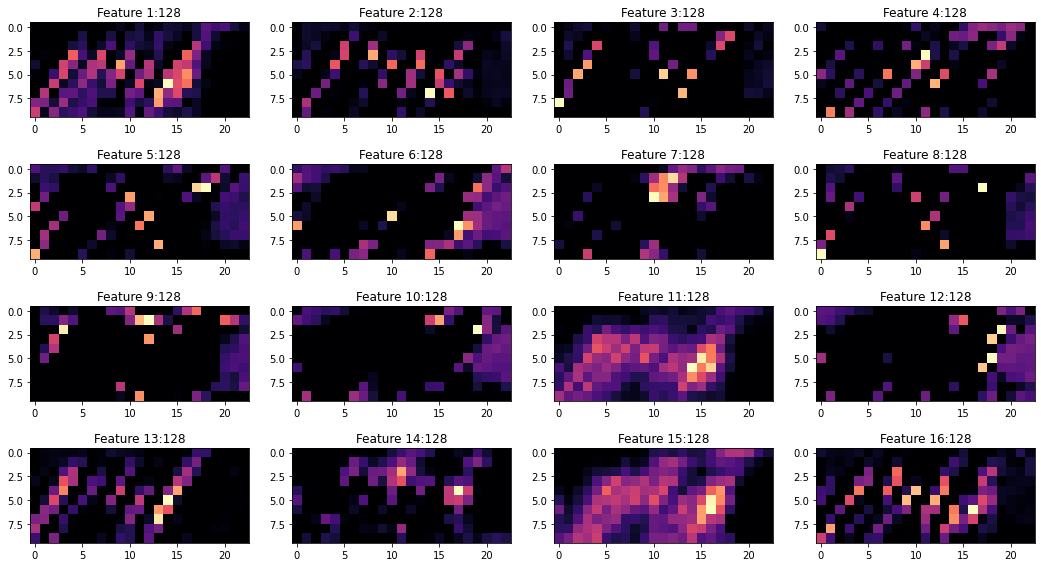

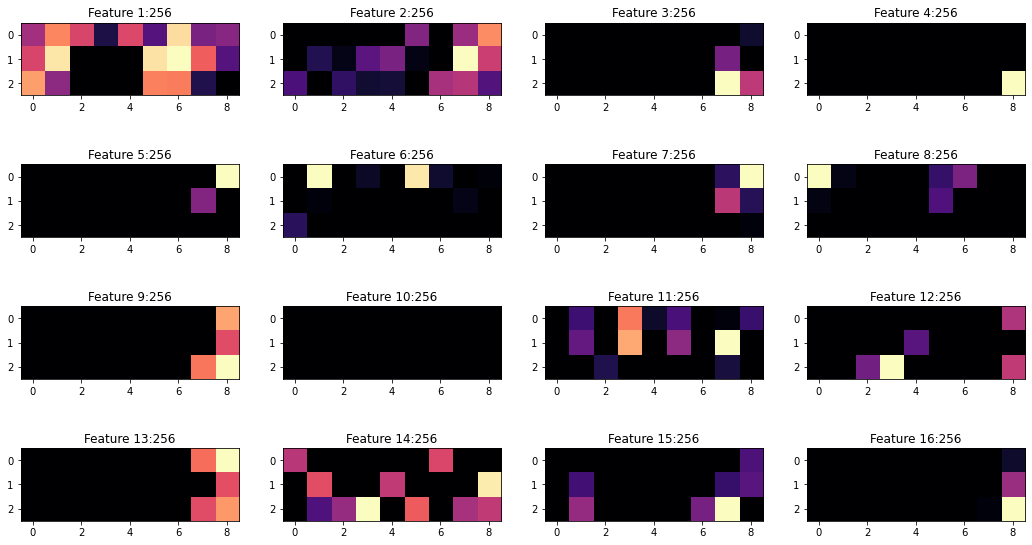

In [81]:
#Visualize feature maps for convolutional layers
layers = [visualize_layer0.predict(image), visualize_layer3.predict(image), visualize_layer6.predict(image),visualize_layer9.predict(image)]
layer_size = [32,64,128,256]
n = 0

for layer in layers:
    plt.figure(figsize=(18,10))
    for i in range(1,17):
        plt.subplot(4,4,i)
        plt.imshow(layer[0,:,:,i-1] , cmap='magma')
        layer_num = 'Feature '+str(i)+':'+str(layer_size[n])
        plt.title(layer_num)    
    n+=1
    plt.show()

####  Model D

Print layer names.

In [82]:
for i in range(len(loaded_D.layers)):
    layer = loaded_D.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

1 conv2d_4 (None, 54, 104, 32)
4 conv2d_5 (None, 25, 50, 64)
7 conv2d_6 (None, 10, 23, 128)
11 conv2d_7 (None, 3, 9, 256)


Visualize layers and save on variables.

In [83]:
visualize_layer0 = tf.keras.Model(inputs=loaded_D.inputs , outputs=loaded_D.layers[1].output)
visualize_layer3 = tf.keras.Model(inputs=loaded_D.inputs , outputs=loaded_D.layers[4].output)
visualize_layer6 = tf.keras.Model(inputs=loaded_D.inputs , outputs=loaded_D.layers[7].output)
visualize_layer9 = tf.keras.Model(inputs=loaded_D.inputs , outputs=loaded_D.layers[11].output)

Visualize the first 16 layer outputs in each block

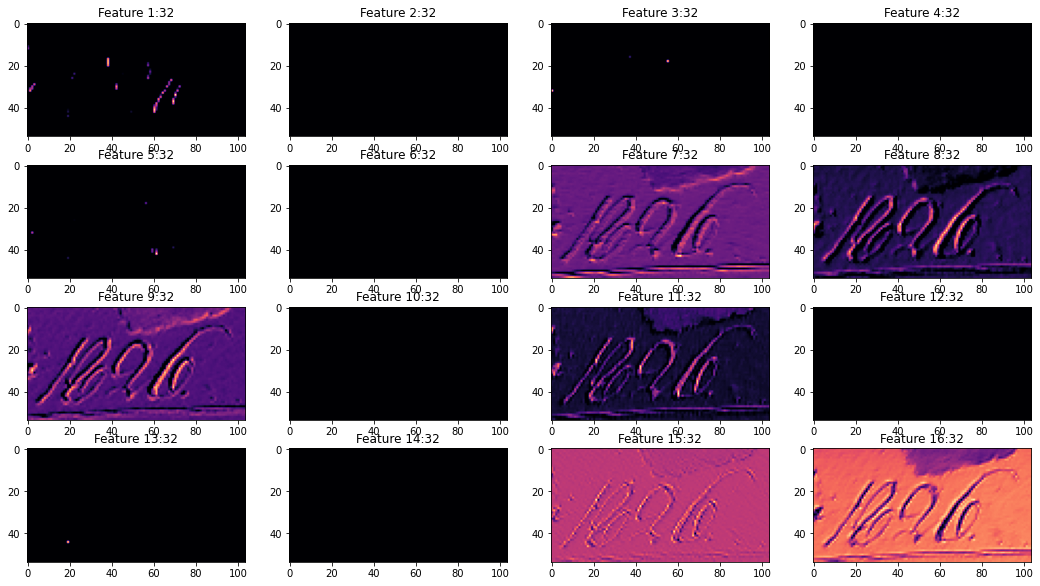

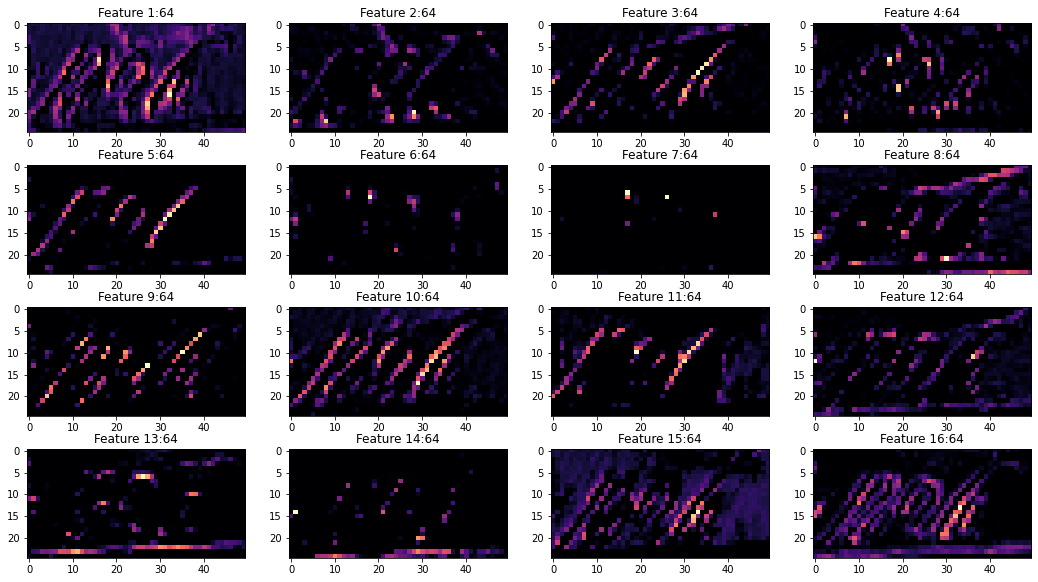

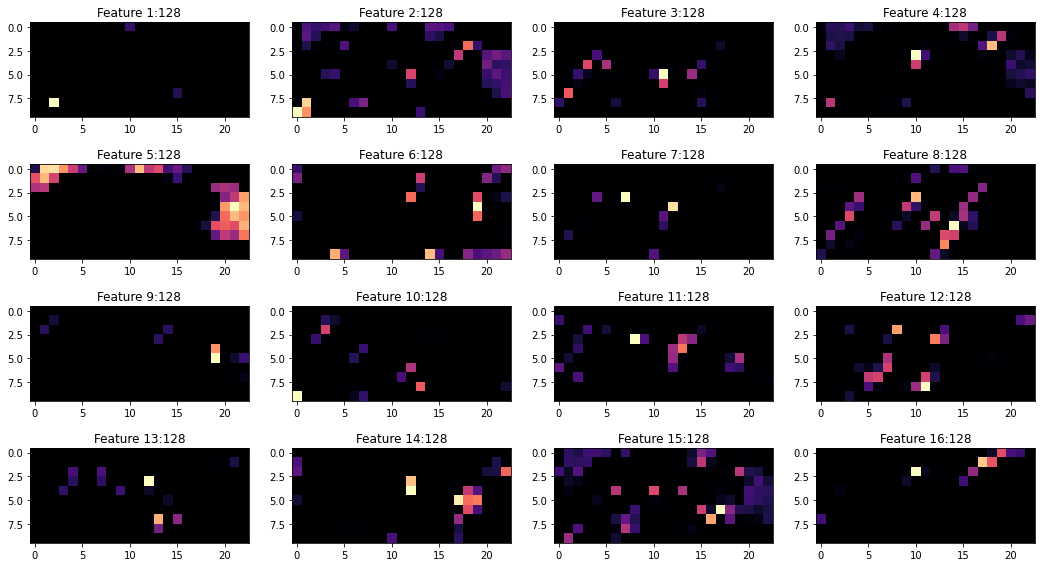

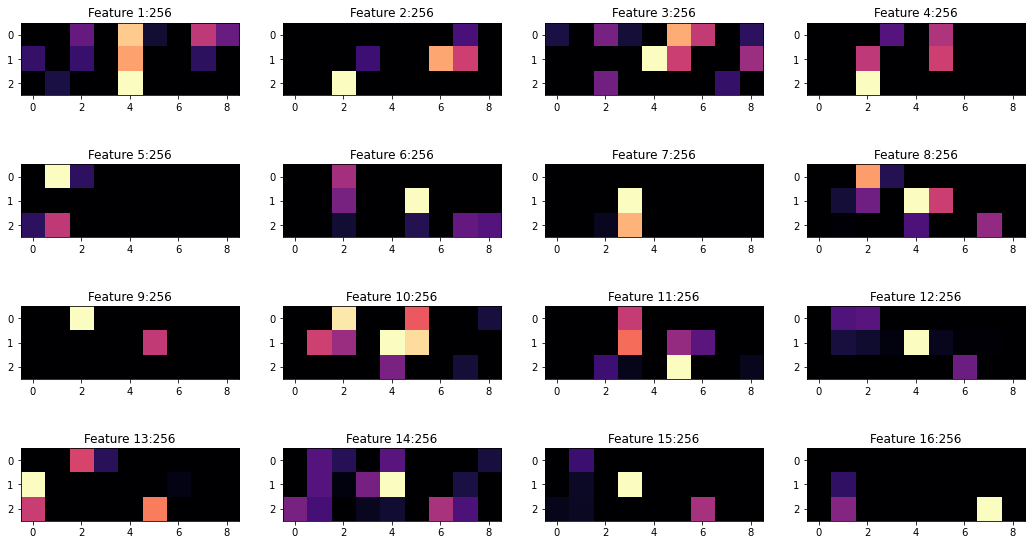

In [85]:
#Visualize feature maps for convolutional layers
layers = [visualize_layer0.predict(image), visualize_layer3.predict(image), visualize_layer6.predict(image),visualize_layer9.predict(image)]
layer_size = [32,64,128,256]
n = 0

for layer in layers:
    plt.figure(figsize=(18,10))
    for i in range(1,17):
        plt.subplot(4,4,i)
        plt.imshow(layer[0,:,:,i-1] , cmap='magma')
        layer_num = 'Feature '+str(i)+':'+str(layer_size[n])
        plt.title(layer_num)    
    n+=1
    plt.show()

#### Model Y

Print layer names.

In [65]:
for i in range(len(loaded_Y.layers)):
    layer = loaded_Y.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

1 conv2d_8 (None, 54, 104, 32)
5 conv2d_9 (None, 25, 50, 64)
9 conv2d_10 (None, 10, 23, 128)
13 conv2d_11 (None, 3, 9, 256)


Visualize layers and save on variables.

In [66]:
visualize_layer0 = tf.keras.Model(inputs=loaded_Y.inputs , outputs=loaded_Y.layers[1].output)
visualize_layer3 = tf.keras.Model(inputs=loaded_Y.inputs , outputs=loaded_Y.layers[5].output)
visualize_layer6 = tf.keras.Model(inputs=loaded_Y.inputs , outputs=loaded_Y.layers[9].output)
visualize_layer9 = tf.keras.Model(inputs=loaded_Y.inputs , outputs=loaded_Y.layers[13].output)

Visualize the first 16 layer outputs in each block.

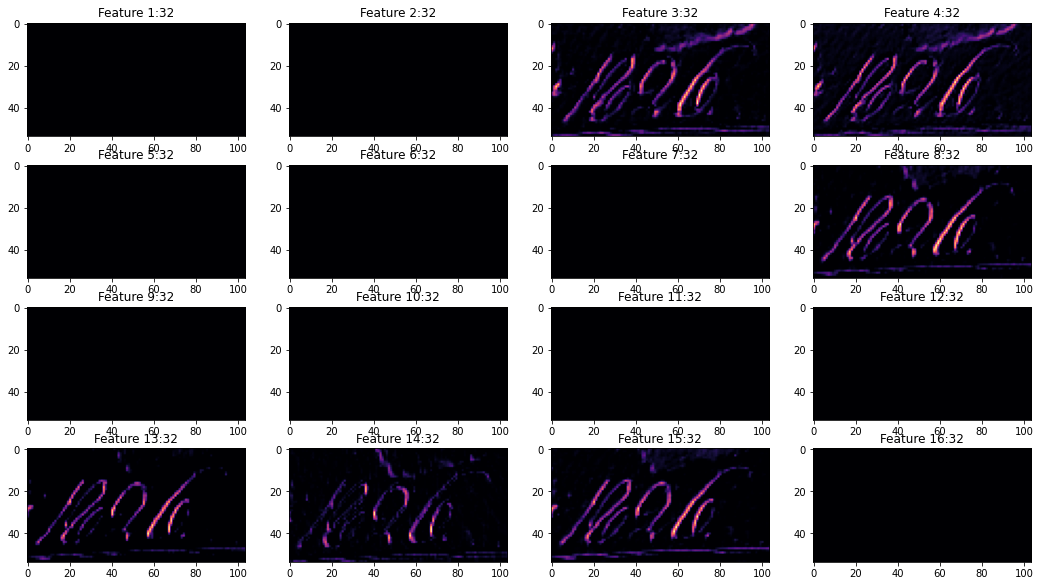

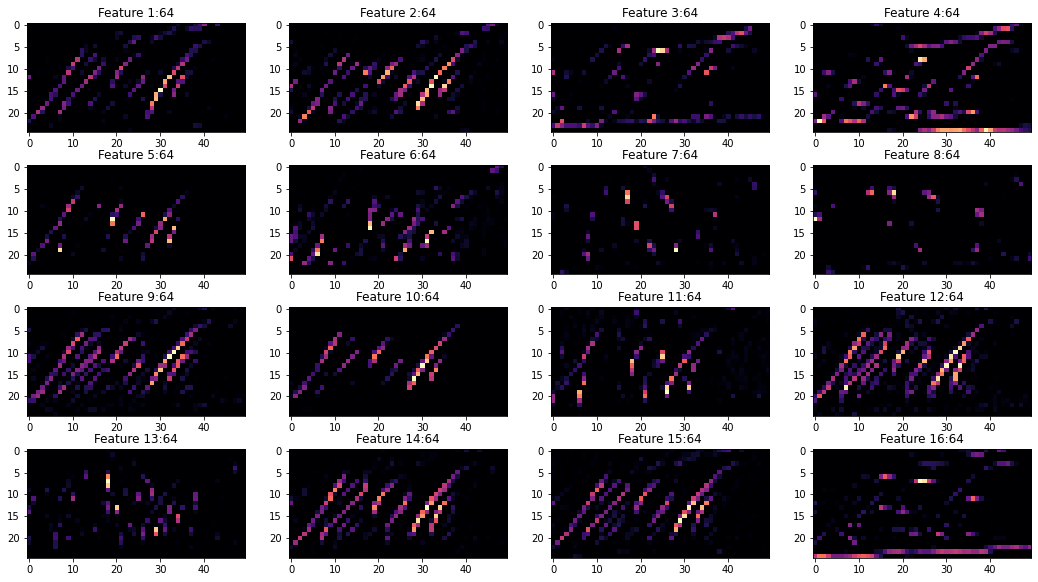

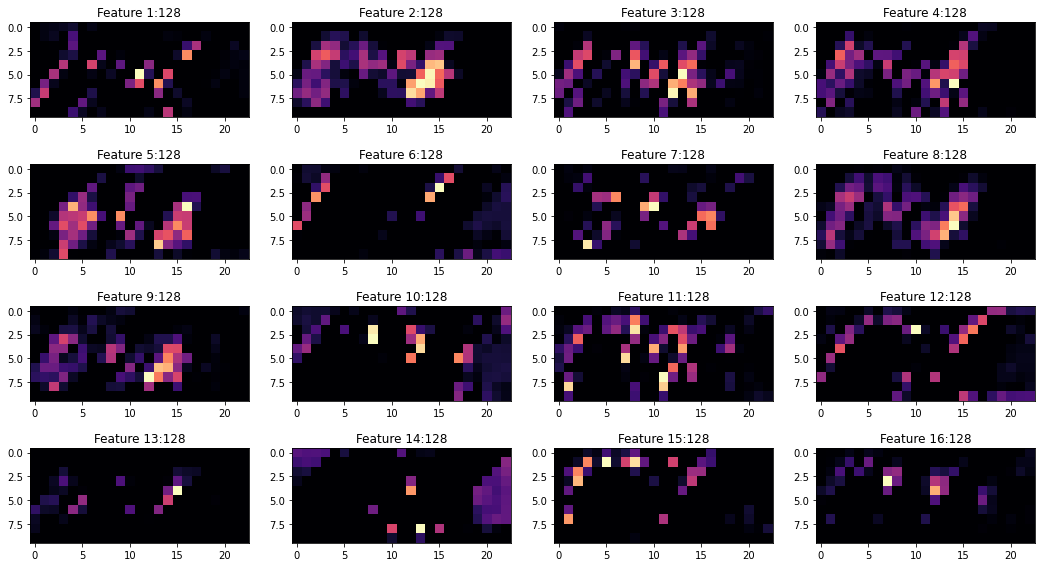

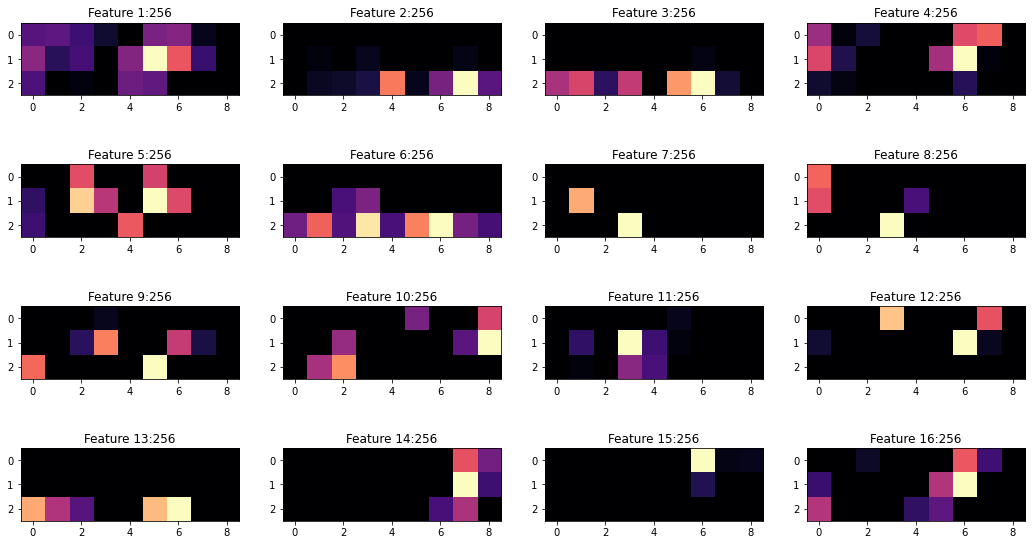

In [68]:
#Visualize feature maps for convolutional layers
layers = [visualize_layer0.predict(image), visualize_layer3.predict(image), visualize_layer6.predict(image),visualize_layer9.predict(image)]
layer_size = [32,64,128,256]
n = 0

for layer in layers:
    plt.figure(figsize=(18,10))
    for i in range(1,17):
        plt.subplot(4,4,i)
        plt.imshow(layer[0,:,:,i-1] , cmap='magma')
        layer_num = 'Feature '+str(i)+':'+str(layer_size[n])
        plt.title(layer_num)    
    n+=1
    plt.show()

### Heatmaps

Define functions for reading in images, creating heatmaps and overlaying them on imagery. 

Functions are derived from Tensorflow documentation. 

https://keras.io/examples/vision/grad_cam/

In [294]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, layer, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.layers[layer].output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(digits,heatmap, cam_path="cam.jpg", alpha=0.7):
    # Load the original image
    img = digits

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

#### Model CC

Generate heat map for select image.

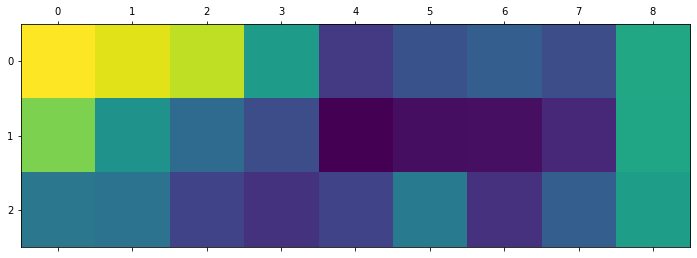

In [298]:
# Prepare image
img_array = x_test[49:50]

# Make model
model = loaded_CC

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# Generate class activation heatmap
print(model.layers[17])
heatmap = make_gradcam_heatmap(img_array, model,13)

# Display heatmap
plt.matshow(heatmap)
plt.show()

Overlay heatmap on image.

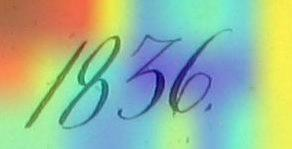

In [299]:
image=plt.imread('DIDA_12000_String_Digit_Images/DIDA_1/50.jpg')
save_and_display_gradcam(image,heatmap)

#### Model D

Generate heat map for select image.

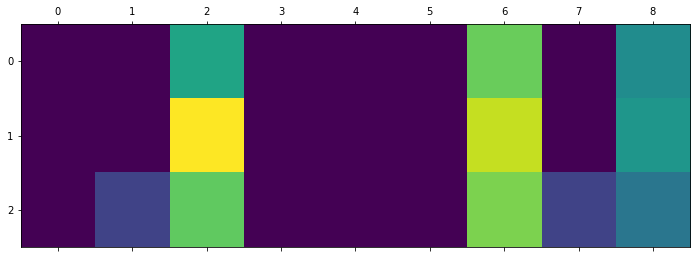

In [295]:
# Prepare image
img_array = x_test[49:50]

# Make model
model = loaded_D

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# Generate class activation heatmap
#print(model.layers[17])
heatmap = make_gradcam_heatmap(img_array, model,11)

# Display heatmap
plt.matshow(heatmap)
plt.show()

Overlay heatmap on image.

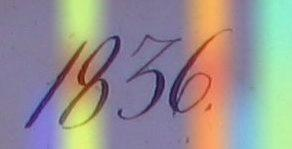

In [290]:
image=plt.imread('DIDA_12000_String_Digit_Images/DIDA_1/50.jpg')
save_and_display_gradcam(image,heatmap)

#### Model Y


Generate heat map for select image.

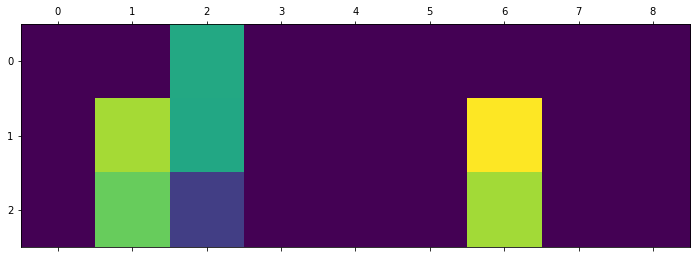

In [296]:
# Prepare image
img_array = x_test[1:2]

# Make model
model = loaded_Y

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# Generate class activation heatmap
print(model.layers[17])
heatmap = make_gradcam_heatmap(img_array, model,13)

# Display heatmap
plt.matshow(heatmap)
plt.show()

Overlay heatmap on image.

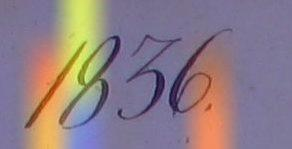

In [297]:
image=plt.imread('DIDA_12000_String_Digit_Images/DIDA_1/50.jpg')
save_and_display_gradcam(image,heatmap)

### Filter visualization, model D only

Define function from curriculum for generating pattern on select image.

In [311]:
def tidy_image(image):
    image = image.numpy()[0]
    image -= image.mean()
    image /= (image.std() + 0.00001)
    image *= 0.1
    image += 0.5
    image = np.clip(image, 0, 1)
        
    return image
    
def generate_pattern(layer_name, filter_index, im_size, model):
    #submodel = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output])
    submodel = tf.keras.models.Model([model.inputs], [model.layers[layer_name].output])
    input_img_data = np.random.random((1, *im_size))
    input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

    # Iterate gradient ascents
    for _ in range(100):
        with tf.GradientTape() as tape:
            outputs = submodel(input_img_data)
            loss_value = tf.reduce_mean(outputs[:, :, :, filter_index])
        grads = tape.gradient(loss_value, input_img_data)
        normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
        input_img_data.assign_add(normalized_grads * 1.0)
        
    return tidy_image(input_img_data)


Plot patterns, deriving from model D.

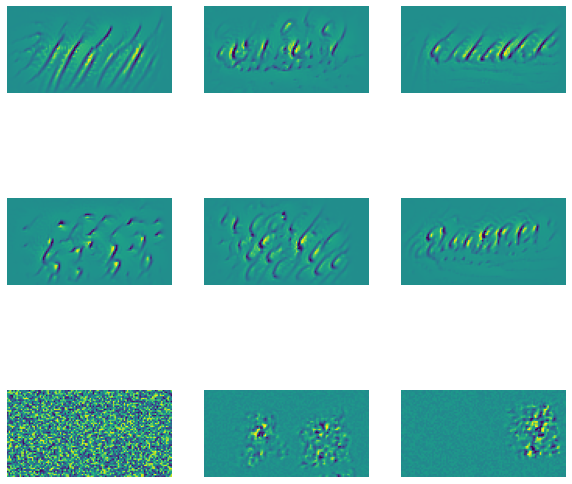

In [316]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1); plt.axis('off'); plt.imshow(generate_pattern(13, i, (56, 106, 1),loaded_Y))

## Question 3.2

The CC model in this chapter is dependant on 2.2.D "CC revised, 50/50 label balance".

#### Loading optimized VGG4 models from 2.2.C.

In [16]:
loaded_D  = tf.keras.models.load_model('models/D_CNN_Final.h5')
loaded_Y = tf.keras.models.load_model('models/Y_CNN_Final.h5')

### Confusion matrixes on DIDA_30k test set

#### Model CC

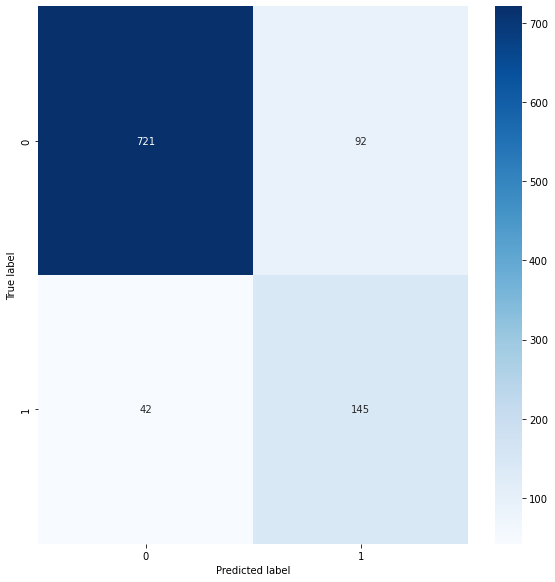

In [95]:
pred_CC = np.argmax(transfer_model_CC.predict(k30_img_RGB), axis=1)
k30_labels_CC.astype(int)
matrix = tf.math.confusion_matrix(k30_labels_CC.astype(int),results)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(matrix, annot=True,cmap=plt.cm.Blues, fmt='d')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### Model D

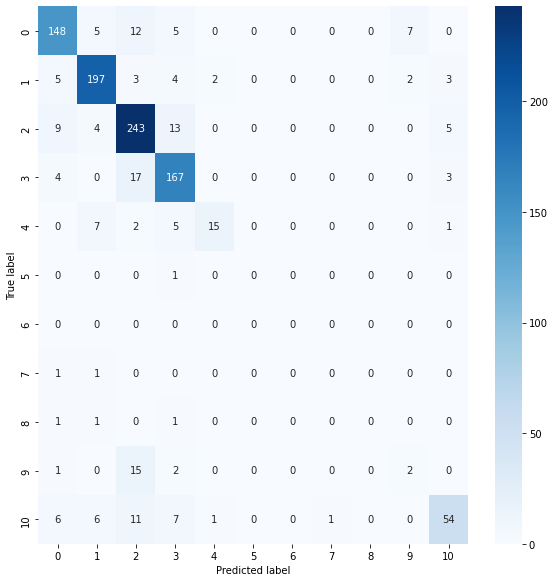

In [93]:
pred_D = np.argmax(loaded_D.predict(k30_img_vals), axis=1)
matrix = tf.math.confusion_matrix(k30_labels_D.astype(int),pred_D)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(matrix, annot=True,cmap=plt.cm.Blues, fmt='d')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#### Model Y

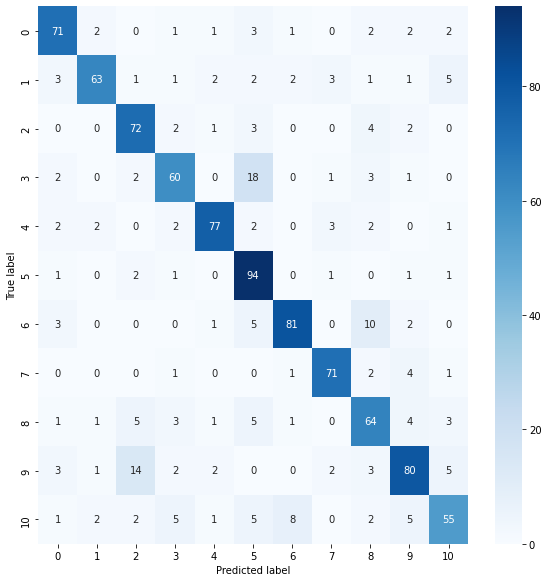

In [94]:
pred_Y = np.argmax(loaded_Y.predict(k30_img_vals), axis=1)
k30_labels_Y.astype(int)
matrix = tf.math.confusion_matrix(k30_labels_Y.astype(int),pred_Y)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()